Выполнила Андрющенко К.С.

## Домашнее задание: Классификация 128x128 + U-Net c бэкбоном

### Датасеты

Создадим загрузчики для обоих наборов данных, добавим аугментации для обучения (отражения и повороты), не искожающие сильно пропорции объектов

In [37]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 4060 Ti


In [119]:
from torchvision import transforms, models, datasets
from PIL import Image
import torch
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2
import numpy as np
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import torch

In [39]:
transform = A.Compose([
    A.Resize(128, 128),
    ToTensorV2()
])

**Датасет tiny-imagenet-200**

In [40]:
import os
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', augmentation=None, 
                max_classes=21, selected_classes=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        augmentation: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.augmentation = augmentation
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(f"Папки {root_dir} нет простите пожалуйста")
        # все классы
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            all = [line.strip() for line in f]

        if selected_classes:
            self.class_names = [cls for cls in selected_classes if cls in all]
            if len(self.class_names) != len(selected_classes):
                print(f"Внимание: {len(selected_classes) - len(self.class_names)} классов не найдено в датасете")
        elif max_classes:       
            self.class_names = all[:max_classes]
        else:
            self.class_names = all
        valid_classes = set(self.class_names)
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        self.samples = []

        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                if cls not in valid_classes:
                    continue
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    # путь к файлу и индекс
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    if cls in valid_classes:
                        label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        if image is None:
            print(f"Ошибка загрузки: {img_path}")
            # Возвращаем черное изображение как заглушку
            image = np.zeros((64, 64, 3), dtype=np.uint8)
        else:
            # Конвертируем BGR в RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Применяем аугментации
        if self.augmentation:
            augmented = self.augmentation(image=image)
            image = augmented['image']
        
        return image, label

Выбранные классы

* n03854065	organ, pipe organ
* n03670208	limousine, limo

* n03447447	gondola

* n03393912	freight car

* n03089624	confectionery, confectionary, candy store

* n02814860	beacon, lighthouse, beacon light, pharos

* n02793495	barn

* n02113799	standard poodle
* n03179701	desk

* n03388043	fountain

* n03126707	crane

* n02814533	beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon

* n02892201	brass, memorial tablet, plaque

* n02788148	bannister, banister, balustrade, balusters, handrail

* n02699494	altar

* n02124075	Egyptian cat

* n02123394	Persian cat

* n02085620	Chihuahua

* n02099601	golden retriever

* n01443537	goldfish, Carassius auratus

* n09256479	coral reef

In [41]:
selected_classes = [
    'n03854065',  # organ, pipe organ
    'n03670208',  # limousine, limo
    'n03447447',  # gondola
    'n03393912',  # freight car
    'n03089624',  # confectionery, confectionary, candy store
    'n02814860',  # beacon, lighthouse, beacon light, pharos
    'n02793495',  # barn
    'n02113799',  # standard poodle
    'n03179701',  # desk
    'n03388043',  # fountain
    'n03126707',  # crane
    'n02814533',  # beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
    'n02892201',  # brass, memorial tablet, plaque
    'n02788148',  # bannister, banister, balustrade, balusters, handrail
    'n02699494',  # altar
    'n02124075',  # Egyptian cat
    'n02123394',  # Persian cat
    'n02085620',  # Chihuahua
    'n02099601',  # golden retriever
    'n01443537',  # goldfish, Carassius auratus
    'n09256479'   # coral reef
]

In [42]:
root = "tiny_data/tiny-imagenet-200"
train_dataset = TinyImageNetDataset(root_dir=root, split='train', augmentation=transform, selected_classes=selected_classes)
train_loader = DataLoader(train_dataset, batch_size=10, num_workers=0)

Параметры для нормализации

In [43]:
channels_sum = torch.zeros(3)
channels_sq_sum = torch.zeros(3)
num_batches = 0
with torch.no_grad():
    for data, _ in train_loader:
        data = data.float() / 255.0
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sq_sum += torch.mean(data**2, dim=[0, 2, 3])
        
        num_batches += 1

mean = channels_sum / num_batches
std = (channels_sq_sum / num_batches - mean ** 2) ** 0.5

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4608, 0.4331, 0.3976])
Std: tensor([0.2590, 0.2508, 0.2661])


Размеры исходных изображений:
* tiny - 60x60
* moon - 720x480


Для tiny растянем изображение, пропорции при этом сохраняются. В качестве аугментации будем использовать горизонтальное отражение, вертикальное не используем т.к. это нелогично для некоторых классов (машины не ездят по потолку), для реалистичных наклонов и масштабирований используем преобразование ```ShiftScaleRotate``` добавим изменение цветовых параметров, чтобы не было заучивания конкретных оттенков. Для опору не только на локальные признаки, а на контекст - создание пробелов на изображении ```CoarseDropout ``` 

In [44]:
train_transform_tiny = A.Compose([
A.Resize(128, 128),
A.HorizontalFlip(p=0.5),
A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5), # Мягкий поворот лучше чем 90 градусов
A.CoarseDropout(max_holes=2, max_height=16, max_width=16, p=0.5),
A.ColorJitter(p=0.5, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
A.Normalize(mean=(0.4608, 0.4331, 0.3976), std=(0.2590, 0.2508, 0.2661)),
ToTensorV2()

])
val_transform_tiny = A.Compose([
A.Resize(128, 128),
A.Normalize(mean=(0.4608, 0.4331, 0.3976), std=(0.2590, 0.2508, 0.2661)),
ToTensorV2()
])

In [45]:
train_dataset_tiny = TinyImageNetDataset(root, split='train', augmentation=train_transform_tiny)
val_dataset_tiny = TinyImageNetDataset(root, split='val', augmentation=val_transform_tiny)

train_loader_tiny = DataLoader(train_dataset_tiny, batch_size=64, shuffle=True, num_workers=0)
val_loader_tiny = DataLoader(val_dataset_tiny, batch_size=64, shuffle=False, num_workers=0)


**Датасет MOON_SEGMENTATION_BINARY**

render/ - исходные изображения лунной поверхности (1000 изображений)   
ground/ - бинарные маски сегментации (0 = фон, 255 = камни)   

In [ ]:
class MoonSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        self.images_dir = os.path.join(root_dir, 'images', image_folder)
        self.masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        self.valid_pairs = []
        
      
        if image_ids is None:
            all_files = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.png')])
            image_ids = [f.replace('.png', '') for f in all_files]
            
        for img_id in image_ids:
            img_path = os.path.join(self.images_dir, f"{img_id}.png")
            
            mask_id_clean = img_id.replace('render', '') if 'render' in img_id else img_id
            mask_path = os.path.join(self.masks_dir, f"ground{mask_id_clean}.png")
            
            if os.path.exists(img_path) and os.path.exists(mask_path):
                self.valid_pairs.append({
                    'img_path': img_path,
                    'mask_path': mask_path
                })
            else:
                pass

    def __len__(self):
        return len(self.valid_pairs)
    
    def __getitem__(self, idx):
        pair = self.valid_pairs[idx]
        image = cv2.imread(pair['img_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(pair['mask_path'], cv2.IMREAD_GRAYSCALE)
        
        mask = (mask > 0).astype(np.float32)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
     # делаем [1, H, W]
        if isinstance(mask, torch.Tensor):
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
        elif isinstance(mask, np.ndarray):
            if mask.ndim == 2:
                mask = mask[np.newaxis, :, :]
                mask = torch.from_numpy(mask)

        return image, mask

In [48]:
# Путь к данным
DATA_ROOT = "MOON_SEGMENTATION_BINARY/"

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")


Всего изображений: 1000
Train: 800 изображений
Val: 200 изображений


Для автоматической синхронизации image и mask.изображение и маска трансформируются одинаково. Иначе пиксели маски перестанут соответствовать объектам на изображении. Пропорции исходного изображения 720х480, если просто сделать resize объекты сплющаться и могут перестать быть интерпретируенмы. Если сделать паддинг до 720х720, а потом resize, то кратеры станут слишком мелаими и будут похожи на шум. Чтобы не искажать объекты и сохранить адекватный размер можно использовать RandomCrop(128,128) (на валидации можно CenterCrop для интерпритируемости) или можоно RandomCrop(256, 256) + Resize(128,128), чтобы захватить больше объектов с изображения изначального.

In [49]:
train_augmentation_moon = A.Compose([
    # A.RandomCrop(height=128, width=128),
    A.CenterCrop(height=256, width=256),
    A.Resize(128,128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_augmentation_moon = A.Compose([
    # A.CenterCrop(height=128, width=128),
    A.CenterCrop(height=256, width=256),
    A.Resize(128,128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [50]:
train_dataset_moon = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation_moon
)

val_dataset_moon = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation_moon
)

In [51]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_loader_moon = DataLoader(
    train_dataset_moon, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader_moon = DataLoader(
    val_dataset_moon, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)
print(f"Батчей в train: {len(train_loader_moon)}")
print(f"Батчей в val: {len(val_loader_moon)}")

Батчей в train: 25
Батчей в val: 7


Визуализация изображений из загрузчиков обоих датасетов

In [52]:
def denormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

In [53]:

mean_moon = (0.485, 0.456, 0.406)
std_moon = (0.229, 0.224, 0.225)
mean_tiny = (0.4608, 0.4331, 0.3976)
std_tiny = (0.2590, 0.2508, 0.2661)

In [54]:
images, masks = next(iter(train_loader_moon))

In [55]:
def show_images(images, masks=None, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    show_masks = masks is not None
    if show_masks:
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    else:
        fig, axes = plt.subplots(1, 4, figsize=(16, 8))
    for i in range(min(4, len(images))):
        img = denormalize(images[i], mean, std).permute(1, 2, 0).numpy()
        
        if show_masks:
            mask = masks[i].cpu().numpy().squeeze()
            axes[1, i].imshow(mask, cmap='gray')
            axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
            axes[1, i].axis('off')

            axes[0, i].imshow(img)
            axes[0, i].set_title(f"Изображение {i+1}")
            axes[0, i].axis('off')    
        else:
            axes[i].imshow(img)
            axes[i].set_title(f"Изображение {i+1}")
            axes[i].axis('off')                                                                                                 
    plt.tight_layout()
    plt.show()

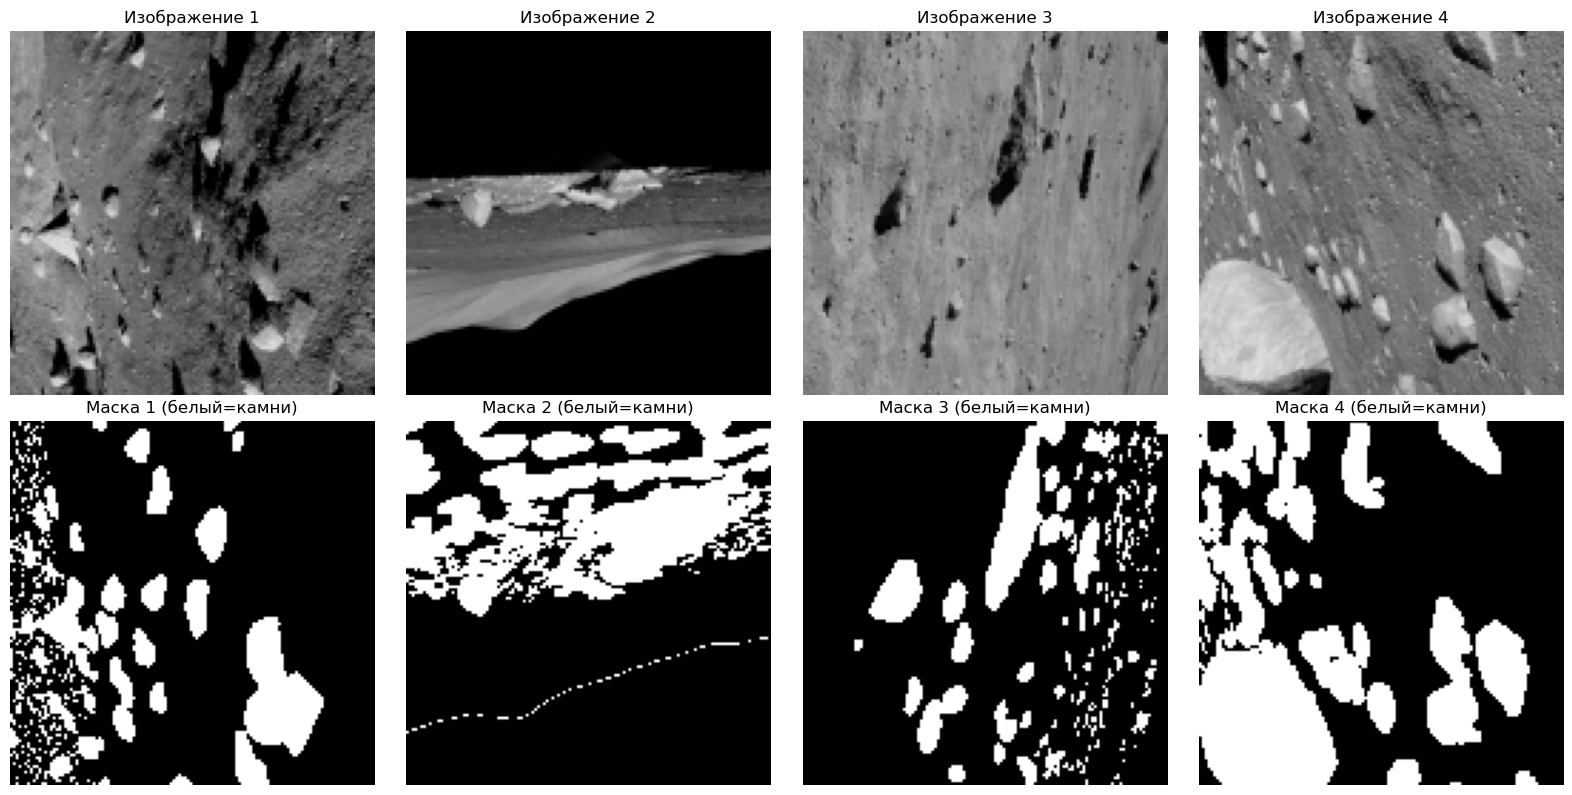

In [56]:
show_images(images, masks=masks, mean=mean_moon, std=std_moon)

In [57]:
images[0].shape

torch.Size([3, 128, 128])

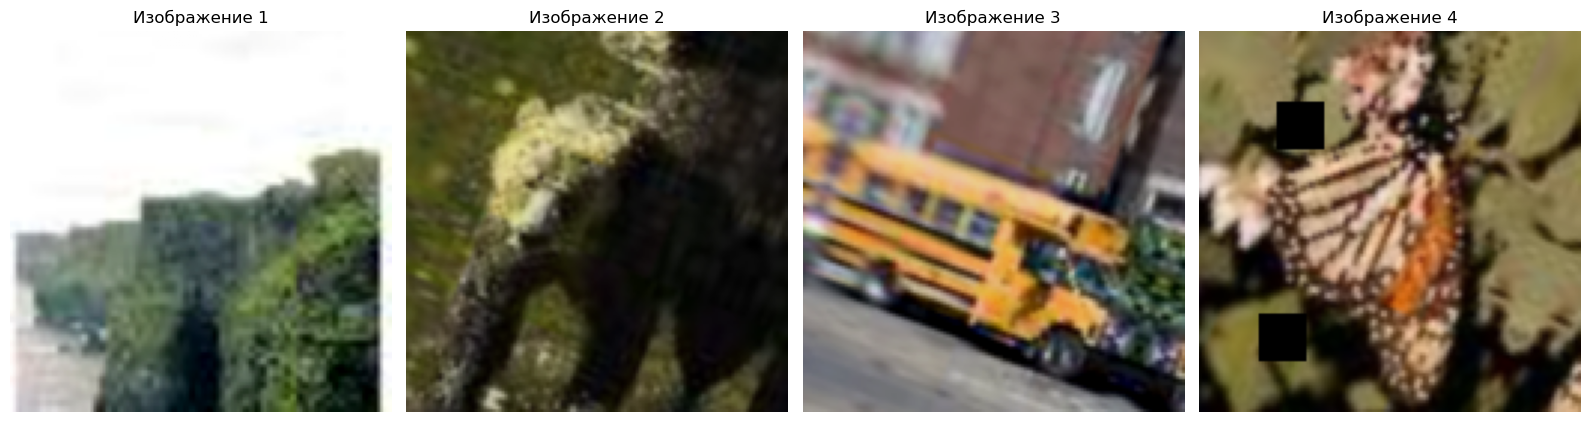

In [58]:
images, labels = next(iter(train_loader_tiny))
show_images(images, masks=None, mean=mean_tiny, std=std_tiny)

In [59]:
images[0].shape

torch.Size([3, 128, 128])

### Часть 1. Классификатор 128×128

Требования к модели:
* Своя архитектура (разрешается вдохновляться CNN-идеями: Conv-BN-ReLU, блоки с даунсемплингом, GAP и т.д.).
* Ограничение на параметризованность: не более ~5M параметров.
* Вход: 128×128×3

Количество классов - 21. Классы были выбраны так, чтобы были категории содержащие объекты похожих форм, чтобы "усложнить задачу"

In [60]:
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Модель**. Предварительные рассуждения: группы классов имеют схожие формы на изображениях (модель должна хорошо работать с небольшими фичами изображения), размер изображения небольшой и классов не много (большой stride и размер ядра maxpool приведет к потере деталей), лимит 5М ограничивает емкость/размер модели (стандартная ResNet18 ~11M). Использование моделей с достаточной емкостью  на таких данных часто ведет к запоминанию обучающей выборки (Overfitting). Для решение проблемы затухающего градиента и чтобы первые слои модели лучше учились (простые формы), можно использовать ResidualBlock. Для инициализации весов *He (Kaiming)* 
   - модификация Xavier под `ReLU`  
   - учитывает, что часть нейронов обнуляется

И для последнего слоя **Xavier (Glorot)**  
   - подбирает дисперсию весов так, чтобы сигналы сохраняли масштаб при прохождении через слои  
   - хорошо работает для `tanh` и `sigmoid`  

Ищем баланс между емкостью модели и обобщающей способностью, можно попробовать не упрощать архитектуру чрезмерно, а усложнить задачу обучения. модель с небольшим "запасом" по параметрам, но более жесткие ограничения на процесс оптимизации. Можно добавить выключение случайных нейронов, чтобы модель учила более надежные признаки/

**Обучение**. Учитывая наличие похожих классов можно добавить Label Smoothing для предотвращения переобучения засчет добавления "сомнений" модели. Для предотвращения переобучения и устойчивости модели можно добавить MixUp ( для подсчета точности на train из output MixUp возьмем "доминирующий" класс,  сравниваем с оригинальной меткой label, однако такая тренировочная accuracy не будет сопоставима с валидационной, потому что модель учится предсказывать смесь классов, а мы проверяем её как будто она видела чистые примеры, но можно будет увидеть прогресс обучения), добавим как опцию и посмотрим что получится. 
*MixUp добавлен ради эксперимента, использовать его для интерпритации результатов в соответствии с заданием мы не будем*

In [ ]:
def train_tiny(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, use_mixup=False, mixup_alpha=0.2):
    model = model.to(device)
    history = {
        'loss_train': [],
        'acc_train': [],
        'loss_val': [],
        'acc_val': []
    }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # MIXUP
            if use_mixup and mixup_alpha > 0:
                # MIXUP ВКЛЮЧЕН
                lam = np.random.beta(mixup_alpha, mixup_alpha)
                index = torch.randperm(images.size(0)).to(device)
                mixed_images = lam * images + (1 - lam) * images[index, :]
                
                # предсказания на смешанных изображениях
                output = model(mixed_images)
                
                # Loss с интерполяцией меток
                y_a, y_b = labels, labels[index]
                loss = lam * criterion(output, y_a) + (1 - lam) * criterion(output, y_b)
                
                #  используем доминирующий класс из смеси
                _, predicted = torch.max(output.data, 1)
                train_total += labels.size(0)
                # сравниваем с оригинальной меткой (хотя это не совсем честно)
                train_correct += (predicted == labels).sum().item()
                
            else:
                #без MIXUP 
                output = model(images)
                loss = criterion(output, labels)
                
     
                _, predicted = torch.max(output.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_correct / train_total
        
        history['loss_train'].append(avg_train_loss)
        history['acc_train'].append(avg_train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_correct / val_total
        
        history['loss_val'].append(avg_val_loss)
        history['acc_val'].append(avg_val_acc)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_acc)
            else:
                scheduler.step()

        print(f'Epoch {epoch+1}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print(' ^-^ ' * 60)
        
    return model, history

In [62]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1,  bias=False)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1, bias=False)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.down_sample = nn.Identity()
        if in_channels != out_channels or stride != 1:
            self.down_sample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
                
            )

    def forward(self, x):
        identity = x
        if self.down_sample is not None:
            identity = self.down_sample(x)
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu(out)
        # 2 слой
        out = self.conv2(out)
        out = self.batch2(out)
        # должны быть одинаковые размеры
        out += identity
        out = self.relu(out)
        return out

In [63]:
class CustomLightNet(nn.Module):
    def __init__(self, num_clusses=21):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.LeakyReLU(inplace=True)
        self.basic1 = ResidualBlock(16, 16)
        self.basic2 = ResidualBlock(16, 16) 

        self.basic3 = ResidualBlock(16, 32, stride=2)
        self.basic4 = ResidualBlock(32, 32, stride=1) 

        self.basic5 = ResidualBlock(32, 64, stride=2)
        self.basic6 = ResidualBlock(64, 64, stride=1) 

        self.basic7 = ResidualBlock(64, 128, stride=2)
        self.basic8 = ResidualBlock(128, 128, stride=1) 

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        #  Dropout
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(128, num_clusses)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.relu((self.bn1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))
        out = self.basic4(self.basic3(out))
        out = self.basic6(self.basic5(out))
        out = self.basic8(self.basic7(out))
        
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        
        out = self.dropout(out)
        
        out = self.fc(out)
        return out

In [64]:
model_ResNet = CustomLightNet(num_clusses=21) 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer_ResNet = torch.optim.AdamW(model_ResNet.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 80
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ResNet, 
    mode='max', 
    factor=0.5, 
    patience=5, 
    verbose=True
)

c:\Users\Xenia\anaconda3\envs\cv_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [65]:
trained_model_ResNet, history_ResNet = train_tiny(
    model=model_ResNet,
    train_loader=train_loader_tiny, 
    val_loader=val_loader_tiny,    
    criterion=criterion,
    optimizer=optimizer_ResNet,
    scheduler=scheduler,
    epochs=epochs,
    device=device
)

Epoch 1/80: 100%|██████████| 165/165 [00:56<00:00,  2.90it/s]


Epoch 1: Train Loss: 2.9965, Train Acc: 0.1253, Val Loss: 2.7325, Val Acc: 0.2133
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/80: 100%|██████████| 165/165 [00:20<00:00,  8.24it/s]


Epoch 2: Train Loss: 2.7568, Train Acc: 0.1980, Val Loss: 2.6132, Val Acc: 0.2390
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/80: 100%|██████████| 165/165 [00:19<00:00,  8.31it/s]


Epoch 3: Train Loss: 2.5985, Train Acc: 0.2538, Val Loss: 2.6217, Val Acc: 0.2848
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/80: 100%|██████████| 165/165 [00:19<00:00,  8.33it/s]


Epoch 4: Train Loss: 2.4880, Train Acc: 0.3025, Val Loss: 2.3282, Val Acc: 0.3752
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/80: 100%|██████████| 165/165 [00:19<00:00,  8.33it/s]


Epoch 5: Train Loss: 2.3913, Train Acc: 0.3376, Val Loss: 2.2225, Val Acc: 0.4076
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/80: 100%|██████████| 165/165 [00:19<00:00,  8.28it/s]


Epoch 6: Train Loss: 2.3257, Train Acc: 0.3600, Val Loss: 2.2833, Val Acc: 0.3667
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/80: 100%|██████████| 165/165 [00:19<00:00,  8.32it/s]


Epoch 7: Train Loss: 2.2469, Train Acc: 0.3916, Val Loss: 2.1157, Val Acc: 0.4438
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/80: 100%|██████████| 165/165 [00:19<00:00,  8.31it/s]


Epoch 8: Train Loss: 2.1892, Train Acc: 0.4107, Val Loss: 2.0756, Val Acc: 0.4438
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/80: 100%|██████████| 165/165 [00:19<00:00,  8.32it/s]


Epoch 9: Train Loss: 2.1422, Train Acc: 0.4306, Val Loss: 2.0990, Val Acc: 0.4381
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 10: Train Loss: 2.1091, Train Acc: 0.4437, Val Loss: 2.0272, Val Acc: 0.4790
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/80: 100%|██████████| 165/165 [00:19<00:00,  8.27it/s]


Epoch 11: Train Loss: 2.0469, Train Acc: 0.4634, Val Loss: 1.9410, Val Acc: 0.5152
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 12: Train Loss: 2.0114, Train Acc: 0.4779, Val Loss: 1.9979, Val Acc: 0.4771
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 13: Train Loss: 1.9613, Train Acc: 0.4944, Val Loss: 1.8631, Val Acc: 0.5362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 14: Train Loss: 1.9230, Train Acc: 0.5141, Val Loss: 2.2007, Val Acc: 0.4343
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/80: 100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


Epoch 15: Train Loss: 1.8963, Train Acc: 0.5262, Val Loss: 1.8685, Val Acc: 0.5219
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/80: 100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


Epoch 16: Train Loss: 1.8698, Train Acc: 0.5416, Val Loss: 1.9382, Val Acc: 0.5105
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 17: Train Loss: 1.8711, Train Acc: 0.5394, Val Loss: 1.8826, Val Acc: 0.5086
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/80: 100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


Epoch 18: Train Loss: 1.8265, Train Acc: 0.5550, Val Loss: 1.6834, Val Acc: 0.5962
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/80: 100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


Epoch 19: Train Loss: 1.8001, Train Acc: 0.5602, Val Loss: 1.7617, Val Acc: 0.5819
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 20: Train Loss: 1.7767, Train Acc: 0.5770, Val Loss: 1.7898, Val Acc: 0.5648
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 21: Train Loss: 1.7799, Train Acc: 0.5730, Val Loss: 1.7214, Val Acc: 0.5848
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 22: Train Loss: 1.7361, Train Acc: 0.5890, Val Loss: 1.7589, Val Acc: 0.5543
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 23: Train Loss: 1.7210, Train Acc: 0.5966, Val Loss: 1.6855, Val Acc: 0.6086
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 24: Train Loss: 1.6998, Train Acc: 0.6035, Val Loss: 1.6498, Val Acc: 0.6190
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 25: Train Loss: 1.6831, Train Acc: 0.6118, Val Loss: 1.6861, Val Acc: 0.6229
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/80: 100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


Epoch 26: Train Loss: 1.6738, Train Acc: 0.6183, Val Loss: 1.6732, Val Acc: 0.6076
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 27: Train Loss: 1.6534, Train Acc: 0.6237, Val Loss: 1.6529, Val Acc: 0.6143
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 28: Train Loss: 1.6485, Train Acc: 0.6267, Val Loss: 1.7859, Val Acc: 0.5829
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 29: Train Loss: 1.6180, Train Acc: 0.6359, Val Loss: 1.6649, Val Acc: 0.6152
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/80: 100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


Epoch 30: Train Loss: 1.5990, Train Acc: 0.6458, Val Loss: 1.6827, Val Acc: 0.6219
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 31: Train Loss: 1.5874, Train Acc: 0.6439, Val Loss: 1.7196, Val Acc: 0.6048
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 32: Train Loss: 1.5249, Train Acc: 0.6794, Val Loss: 1.5463, Val Acc: 0.6486
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 33: Train Loss: 1.4981, Train Acc: 0.6839, Val Loss: 1.4980, Val Acc: 0.6838
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 34: Train Loss: 1.4851, Train Acc: 0.6908, Val Loss: 1.4751, Val Acc: 0.6867
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 35: Train Loss: 1.4772, Train Acc: 0.6964, Val Loss: 1.4969, Val Acc: 0.6819
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 36: Train Loss: 1.4640, Train Acc: 0.6983, Val Loss: 1.4742, Val Acc: 0.6810
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/80: 100%|██████████| 165/165 [00:20<00:00,  7.93it/s]


Epoch 37: Train Loss: 1.4652, Train Acc: 0.7051, Val Loss: 1.4716, Val Acc: 0.6848
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/80: 100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


Epoch 38: Train Loss: 1.4465, Train Acc: 0.7106, Val Loss: 1.4704, Val Acc: 0.6905
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 39: Train Loss: 1.4627, Train Acc: 0.7012, Val Loss: 1.5143, Val Acc: 0.6705
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/80: 100%|██████████| 165/165 [00:20<00:00,  8.12it/s]


Epoch 40: Train Loss: 1.4382, Train Acc: 0.7140, Val Loss: 1.4528, Val Acc: 0.6886
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 41/80: 100%|██████████| 165/165 [00:19<00:00,  8.28it/s]


Epoch 41: Train Loss: 1.4189, Train Acc: 0.7243, Val Loss: 1.4753, Val Acc: 0.6905
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 42/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 42: Train Loss: 1.4175, Train Acc: 0.7209, Val Loss: 1.4270, Val Acc: 0.6981
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 43/80: 100%|██████████| 165/165 [00:19<00:00,  8.31it/s]


Epoch 43: Train Loss: 1.4092, Train Acc: 0.7267, Val Loss: 1.4727, Val Acc: 0.6848
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 44/80: 100%|██████████| 165/165 [00:19<00:00,  8.33it/s]


Epoch 44: Train Loss: 1.4082, Train Acc: 0.7300, Val Loss: 1.4350, Val Acc: 0.6971
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 45/80: 100%|██████████| 165/165 [00:19<00:00,  8.32it/s]


Epoch 45: Train Loss: 1.3957, Train Acc: 0.7351, Val Loss: 1.5058, Val Acc: 0.6762
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 46/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 46: Train Loss: 1.3837, Train Acc: 0.7388, Val Loss: 1.4155, Val Acc: 0.7114
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 47/80: 100%|██████████| 165/165 [00:19<00:00,  8.29it/s]


Epoch 47: Train Loss: 1.3896, Train Acc: 0.7399, Val Loss: 1.4140, Val Acc: 0.6962
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 48/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 48: Train Loss: 1.3714, Train Acc: 0.7390, Val Loss: 1.4593, Val Acc: 0.6810
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 49/80: 100%|██████████| 165/165 [00:19<00:00,  8.31it/s]


Epoch 49: Train Loss: 1.3882, Train Acc: 0.7329, Val Loss: 1.4376, Val Acc: 0.7095
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 50/80: 100%|██████████| 165/165 [00:19<00:00,  8.29it/s]


Epoch 50: Train Loss: 1.3690, Train Acc: 0.7425, Val Loss: 1.4123, Val Acc: 0.7048
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 51/80: 100%|██████████| 165/165 [00:19<00:00,  8.29it/s]


Epoch 51: Train Loss: 1.3605, Train Acc: 0.7419, Val Loss: 1.4362, Val Acc: 0.7000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 52/80: 100%|██████████| 165/165 [00:20<00:00,  8.02it/s]


Epoch 52: Train Loss: 1.3548, Train Acc: 0.7439, Val Loss: 1.3936, Val Acc: 0.7152
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 53/80: 100%|██████████| 165/165 [00:20<00:00,  7.93it/s]


Epoch 53: Train Loss: 1.3466, Train Acc: 0.7622, Val Loss: 1.4516, Val Acc: 0.7000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 54/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 54: Train Loss: 1.3411, Train Acc: 0.7608, Val Loss: 1.4391, Val Acc: 0.7133
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 55/80: 100%|██████████| 165/165 [00:20<00:00,  7.93it/s]


Epoch 55: Train Loss: 1.3415, Train Acc: 0.7584, Val Loss: 1.4335, Val Acc: 0.7095
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 56/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 56: Train Loss: 1.3251, Train Acc: 0.7592, Val Loss: 1.4410, Val Acc: 0.7105
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 57/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 57: Train Loss: 1.3279, Train Acc: 0.7593, Val Loss: 1.4040, Val Acc: 0.7229
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 58/80: 100%|██████████| 165/165 [00:20<00:00,  7.93it/s]


Epoch 58: Train Loss: 1.3264, Train Acc: 0.7629, Val Loss: 1.4383, Val Acc: 0.7038
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 59/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 59: Train Loss: 1.3313, Train Acc: 0.7624, Val Loss: 1.4117, Val Acc: 0.7286
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 60/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 60: Train Loss: 1.3087, Train Acc: 0.7739, Val Loss: 1.3967, Val Acc: 0.7133
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 61/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 61: Train Loss: 1.2945, Train Acc: 0.7730, Val Loss: 1.4168, Val Acc: 0.7143
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 62/80: 100%|██████████| 165/165 [00:20<00:00,  8.14it/s]


Epoch 62: Train Loss: 1.3021, Train Acc: 0.7722, Val Loss: 1.4198, Val Acc: 0.7143
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 63/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 63: Train Loss: 1.3126, Train Acc: 0.7713, Val Loss: 1.4140, Val Acc: 0.7133
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 64/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 64: Train Loss: 1.2883, Train Acc: 0.7809, Val Loss: 1.4170, Val Acc: 0.7124
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 65/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 65: Train Loss: 1.2846, Train Acc: 0.7819, Val Loss: 1.4389, Val Acc: 0.7057
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 66/80: 100%|██████████| 165/165 [00:19<00:00,  8.27it/s]


Epoch 66: Train Loss: 1.2428, Train Acc: 0.7994, Val Loss: 1.3655, Val Acc: 0.7352
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 67/80: 100%|██████████| 165/165 [00:19<00:00,  8.29it/s]


Epoch 67: Train Loss: 1.2197, Train Acc: 0.8074, Val Loss: 1.3720, Val Acc: 0.7343
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 68/80: 100%|██████████| 165/165 [00:19<00:00,  8.29it/s]


Epoch 68: Train Loss: 1.2238, Train Acc: 0.8059, Val Loss: 1.3621, Val Acc: 0.7267
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 69/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 69: Train Loss: 1.2148, Train Acc: 0.8051, Val Loss: 1.4002, Val Acc: 0.7390
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 70/80: 100%|██████████| 165/165 [00:19<00:00,  8.28it/s]


Epoch 70: Train Loss: 1.2052, Train Acc: 0.8164, Val Loss: 1.3714, Val Acc: 0.7324
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 71/80: 100%|██████████| 165/165 [00:19<00:00,  8.29it/s]


Epoch 71: Train Loss: 1.2078, Train Acc: 0.8087, Val Loss: 1.3717, Val Acc: 0.7295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 72/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 72: Train Loss: 1.2139, Train Acc: 0.8123, Val Loss: 1.3792, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 73/80: 100%|██████████| 165/165 [00:19<00:00,  8.30it/s]


Epoch 73: Train Loss: 1.2122, Train Acc: 0.8120, Val Loss: 1.3785, Val Acc: 0.7381
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 74/80: 100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


Epoch 74: Train Loss: 1.2176, Train Acc: 0.8137, Val Loss: 1.3875, Val Acc: 0.7238
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 75/80: 100%|██████████| 165/165 [00:20<00:00,  7.95it/s]


Epoch 75: Train Loss: 1.1967, Train Acc: 0.8232, Val Loss: 1.3906, Val Acc: 0.7267
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 76/80: 100%|██████████| 165/165 [00:20<00:00,  7.93it/s]


Epoch 76: Train Loss: 1.1775, Train Acc: 0.8288, Val Loss: 1.3580, Val Acc: 0.7400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 77/80: 100%|██████████| 165/165 [00:20<00:00,  7.93it/s]


Epoch 77: Train Loss: 1.1705, Train Acc: 0.8290, Val Loss: 1.3548, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 78/80: 100%|██████████| 165/165 [00:20<00:00,  7.94it/s]


Epoch 78: Train Loss: 1.1705, Train Acc: 0.8278, Val Loss: 1.3563, Val Acc: 0.7371
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 79/80: 100%|██████████| 165/165 [00:20<00:00,  7.93it/s]


Epoch 79: Train Loss: 1.1605, Train Acc: 0.8371, Val Loss: 1.3640, Val Acc: 0.7295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 80/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 80: Train Loss: 1.1728, Train Acc: 0.8314, Val Loss: 1.3588, Val Acc: 0.7371
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


In [67]:
from torchsummary import summary
summary(model_ResNet, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         LeakyReLU-3         [-1, 16, 128, 128]               0
          Identity-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 16, 128, 128]           2,304
       BatchNorm2d-6         [-1, 16, 128, 128]              32
              ReLU-7         [-1, 16, 128, 128]               0
            Conv2d-8         [-1, 16, 128, 128]           2,304
       BatchNorm2d-9         [-1, 16, 128, 128]              32
             ReLU-10         [-1, 16, 128, 128]               0
    ResidualBlock-11         [-1, 16, 128, 128]               0
         Identity-12         [-1, 16, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]           2,304
      BatchNorm2d-14         [-1, 16, 1

In [68]:
def plot_history(history):
   
    loss_train_epoch = history['loss_train']
    loss_val_epoch = history['loss_val']
    accuracy_train_epoch = history['acc_train']
    accuracy_val_epoch = history['acc_val']
    
    # эпохи
    epochs_range = range(1, len(loss_train_epoch) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_train_epoch, label='Train Loss')
    plt.plot(epochs_range, loss_val_epoch, label='Val Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy_train_epoch, label='Train Acc')
    plt.plot(epochs_range, accuracy_val_epoch, label='Val Acc', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

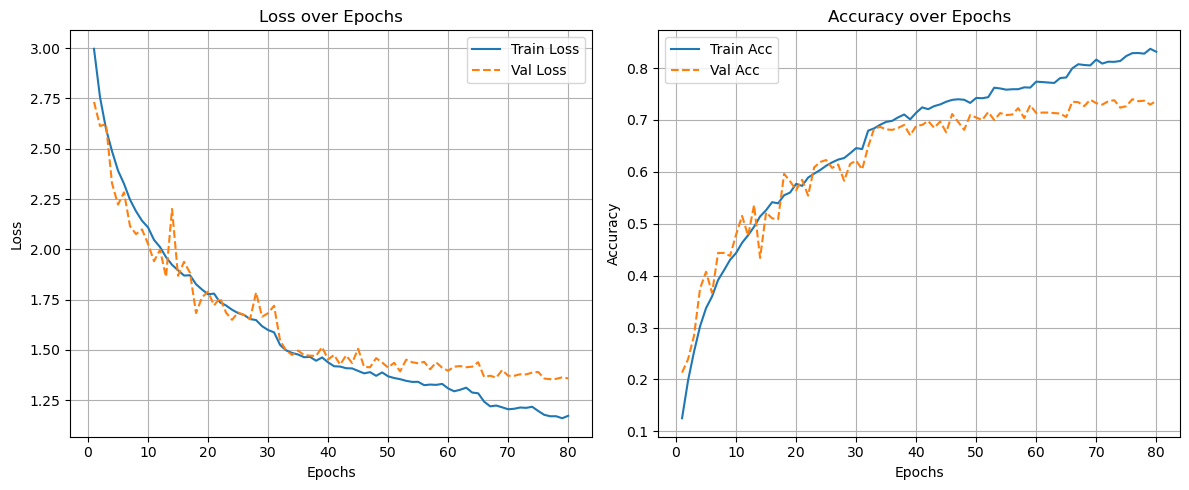

In [69]:
plot_history(history_ResNet)

**итоговые метрики на валидации**

* Epoch 79: Train Loss: 1.1226, Train Acc: 0.8517, Val Loss: 1.3522, Val Acc: 0.7352

* Epoch 80: Train Loss: 1.1170, Train Acc: 0.8531, Val Loss: 1.3406, Val Acc: 0.7362
 

In [70]:
model_ResNet_MixUp = CustomLightNet(num_clusses=21) 
criterion_MixUp = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer_ResNet_MixUp = torch.optim.AdamW(model_ResNet_MixUp.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 80
scheduler_MixUp = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ResNet_MixUp, 
    mode='max', 
    factor=0.5, 
    patience=5, 
    verbose=True
)

trained_model_ResNet_MixUp, history_ResNet_MixUp = train_tiny(
    model=model_ResNet_MixUp,
    train_loader=train_loader_tiny, 
    val_loader=val_loader_tiny,    
    criterion=criterion_MixUp,
    optimizer=optimizer_ResNet_MixUp,
    scheduler=scheduler_MixUp,
    epochs=epochs,
    device=device,
    use_mixup=True
)

Epoch 1/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 1: Train Loss: 3.0374, Train Acc: 0.0939, Val Loss: 2.8637, Val Acc: 0.2210
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 2: Train Loss: 2.7719, Train Acc: 0.1395, Val Loss: 2.5083, Val Acc: 0.3095
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/80: 100%|██████████| 165/165 [00:20<00:00,  7.88it/s]


Epoch 3: Train Loss: 2.6479, Train Acc: 0.1530, Val Loss: 2.4408, Val Acc: 0.2981
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 4: Train Loss: 2.5652, Train Acc: 0.1771, Val Loss: 2.2535, Val Acc: 0.4019
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 5: Train Loss: 2.5014, Train Acc: 0.1770, Val Loss: 2.3772, Val Acc: 0.3562
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 6: Train Loss: 2.4430, Train Acc: 0.2165, Val Loss: 2.1868, Val Acc: 0.4105
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 7: Train Loss: 2.3905, Train Acc: 0.2046, Val Loss: 2.1098, Val Acc: 0.4505
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 8: Train Loss: 2.3620, Train Acc: 0.2201, Val Loss: 2.0413, Val Acc: 0.4714
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 9: Train Loss: 2.3073, Train Acc: 0.2350, Val Loss: 2.1527, Val Acc: 0.4067
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 10: Train Loss: 2.2580, Train Acc: 0.2245, Val Loss: 2.0106, Val Acc: 0.4686
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 11: Train Loss: 2.2497, Train Acc: 0.2771, Val Loss: 2.0532, Val Acc: 0.4524
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/80: 100%|██████████| 165/165 [00:20<00:00,  7.88it/s]


Epoch 12: Train Loss: 2.2082, Train Acc: 0.2981, Val Loss: 1.8706, Val Acc: 0.5295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 13: Train Loss: 2.1770, Train Acc: 0.2698, Val Loss: 1.8924, Val Acc: 0.5257
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 14: Train Loss: 2.1737, Train Acc: 0.2905, Val Loss: 1.9316, Val Acc: 0.4876
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/80: 100%|██████████| 165/165 [00:20<00:00,  7.88it/s]


Epoch 15: Train Loss: 2.1376, Train Acc: 0.2662, Val Loss: 1.8829, Val Acc: 0.5362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 16: Train Loss: 2.0919, Train Acc: 0.2798, Val Loss: 1.9406, Val Acc: 0.4962
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 17: Train Loss: 2.1455, Train Acc: 0.2664, Val Loss: 1.8396, Val Acc: 0.5276
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 18: Train Loss: 2.0874, Train Acc: 0.3118, Val Loss: 1.8508, Val Acc: 0.5552
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/80: 100%|██████████| 165/165 [00:20<00:00,  7.91it/s]


Epoch 19: Train Loss: 2.0888, Train Acc: 0.3112, Val Loss: 1.7397, Val Acc: 0.5867
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 20: Train Loss: 2.0323, Train Acc: 0.2992, Val Loss: 1.7745, Val Acc: 0.5533
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 21: Train Loss: 2.0133, Train Acc: 0.3383, Val Loss: 1.6913, Val Acc: 0.6057
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 22: Train Loss: 2.0399, Train Acc: 0.3189, Val Loss: 1.7076, Val Acc: 0.6038
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 23: Train Loss: 2.0143, Train Acc: 0.3450, Val Loss: 1.7131, Val Acc: 0.5829
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 24: Train Loss: 2.0464, Train Acc: 0.3066, Val Loss: 1.6413, Val Acc: 0.6257
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 25: Train Loss: 1.9249, Train Acc: 0.3319, Val Loss: 1.6460, Val Acc: 0.6086
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 26: Train Loss: 1.9628, Train Acc: 0.3097, Val Loss: 1.6566, Val Acc: 0.6229
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 27: Train Loss: 1.9397, Train Acc: 0.3532, Val Loss: 1.6715, Val Acc: 0.6038
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 28: Train Loss: 1.9589, Train Acc: 0.3053, Val Loss: 1.6786, Val Acc: 0.5943
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 29: Train Loss: 1.9392, Train Acc: 0.3239, Val Loss: 1.6078, Val Acc: 0.6381
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 30: Train Loss: 1.9421, Train Acc: 0.2980, Val Loss: 1.6560, Val Acc: 0.6086
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 31: Train Loss: 1.9091, Train Acc: 0.3271, Val Loss: 1.6217, Val Acc: 0.6419
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 32: Train Loss: 1.8817, Train Acc: 0.3772, Val Loss: 1.5678, Val Acc: 0.6410
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 33: Train Loss: 1.8673, Train Acc: 0.3691, Val Loss: 1.6054, Val Acc: 0.6181
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/80: 100%|██████████| 165/165 [00:20<00:00,  7.87it/s]


Epoch 34: Train Loss: 1.9177, Train Acc: 0.3356, Val Loss: 1.5471, Val Acc: 0.6590
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 35: Train Loss: 1.7914, Train Acc: 0.3528, Val Loss: 1.6055, Val Acc: 0.6390
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 36: Train Loss: 1.8702, Train Acc: 0.3250, Val Loss: 1.5720, Val Acc: 0.6371
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/80: 100%|██████████| 165/165 [00:20<00:00,  7.88it/s]


Epoch 37: Train Loss: 1.8478, Train Acc: 0.3388, Val Loss: 1.5150, Val Acc: 0.6705
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 38: Train Loss: 1.8480, Train Acc: 0.3230, Val Loss: 1.5171, Val Acc: 0.6552
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 39: Train Loss: 1.8460, Train Acc: 0.3620, Val Loss: 1.5239, Val Acc: 0.6590
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 40: Train Loss: 1.8564, Train Acc: 0.3097, Val Loss: 1.5212, Val Acc: 0.6610
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 41/80: 100%|██████████| 165/165 [00:20<00:00,  7.87it/s]


Epoch 41: Train Loss: 1.8222, Train Acc: 0.3085, Val Loss: 1.5564, Val Acc: 0.6543
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 42/80: 100%|██████████| 165/165 [00:21<00:00,  7.84it/s]


Epoch 42: Train Loss: 1.8279, Train Acc: 0.3870, Val Loss: 1.5504, Val Acc: 0.6505
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 43/80: 100%|██████████| 165/165 [00:20<00:00,  7.87it/s]


Epoch 43: Train Loss: 1.7954, Train Acc: 0.3673, Val Loss: 1.5146, Val Acc: 0.6648
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 44/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 44: Train Loss: 1.7301, Train Acc: 0.3626, Val Loss: 1.4227, Val Acc: 0.6943
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 45/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 45: Train Loss: 1.7750, Train Acc: 0.4009, Val Loss: 1.4273, Val Acc: 0.6981
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 46/80: 100%|██████████| 165/165 [00:20<00:00,  7.91it/s]


Epoch 46: Train Loss: 1.7577, Train Acc: 0.3877, Val Loss: 1.3937, Val Acc: 0.7000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 47/80: 100%|██████████| 165/165 [00:20<00:00,  7.87it/s]


Epoch 47: Train Loss: 1.7193, Train Acc: 0.3830, Val Loss: 1.4125, Val Acc: 0.6952
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 48/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 48: Train Loss: 1.6671, Train Acc: 0.3399, Val Loss: 1.4329, Val Acc: 0.7000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 49/80: 100%|██████████| 165/165 [00:20<00:00,  7.91it/s]


Epoch 49: Train Loss: 1.6767, Train Acc: 0.3919, Val Loss: 1.4212, Val Acc: 0.6990
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 50/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 50: Train Loss: 1.7185, Train Acc: 0.3673, Val Loss: 1.4368, Val Acc: 0.7076
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 51/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 51: Train Loss: 1.6817, Train Acc: 0.3815, Val Loss: 1.4529, Val Acc: 0.6895
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 52/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 52: Train Loss: 1.6633, Train Acc: 0.3751, Val Loss: 1.3892, Val Acc: 0.7152
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 53/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 53: Train Loss: 1.7202, Train Acc: 0.3703, Val Loss: 1.4014, Val Acc: 0.7057
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 54/80: 100%|██████████| 165/165 [00:20<00:00,  7.86it/s]


Epoch 54: Train Loss: 1.7530, Train Acc: 0.3887, Val Loss: 1.3944, Val Acc: 0.7048
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 55/80: 100%|██████████| 165/165 [00:21<00:00,  7.85it/s]


Epoch 55: Train Loss: 1.7122, Train Acc: 0.3669, Val Loss: 1.4338, Val Acc: 0.7000
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 56/80: 100%|██████████| 165/165 [00:21<00:00,  7.83it/s]


Epoch 56: Train Loss: 1.6849, Train Acc: 0.4215, Val Loss: 1.3957, Val Acc: 0.7210
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 57/80: 100%|██████████| 165/165 [00:21<00:00,  7.84it/s]


Epoch 57: Train Loss: 1.6633, Train Acc: 0.3985, Val Loss: 1.3963, Val Acc: 0.7114
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 58/80: 100%|██████████| 165/165 [00:21<00:00,  7.85it/s]


Epoch 58: Train Loss: 1.7004, Train Acc: 0.3731, Val Loss: 1.4128, Val Acc: 0.7200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 59/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 59: Train Loss: 1.6535, Train Acc: 0.4001, Val Loss: 1.3833, Val Acc: 0.7276
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 60/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 60: Train Loss: 1.7028, Train Acc: 0.4177, Val Loss: 1.4063, Val Acc: 0.7124
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 61/80: 100%|██████████| 165/165 [00:20<00:00,  7.87it/s]


Epoch 61: Train Loss: 1.6528, Train Acc: 0.3865, Val Loss: 1.4046, Val Acc: 0.7095
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 62/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 62: Train Loss: 1.6644, Train Acc: 0.3937, Val Loss: 1.3912, Val Acc: 0.7190
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 63/80: 100%|██████████| 165/165 [00:20<00:00,  7.91it/s]


Epoch 63: Train Loss: 1.6635, Train Acc: 0.3289, Val Loss: 1.4029, Val Acc: 0.7152
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 64/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 64: Train Loss: 1.6390, Train Acc: 0.4317, Val Loss: 1.3940, Val Acc: 0.7190
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 65/80: 100%|██████████| 165/165 [00:20<00:00,  7.86it/s]


Epoch 65: Train Loss: 1.6109, Train Acc: 0.3861, Val Loss: 1.3679, Val Acc: 0.7286
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 66/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 66: Train Loss: 1.6503, Train Acc: 0.4091, Val Loss: 1.3902, Val Acc: 0.7200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 67/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 67: Train Loss: 1.6899, Train Acc: 0.3920, Val Loss: 1.4207, Val Acc: 0.6962
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 68/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 68: Train Loss: 1.6371, Train Acc: 0.3670, Val Loss: 1.3583, Val Acc: 0.7314
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 69/80: 100%|██████████| 165/165 [00:21<00:00,  7.84it/s]


Epoch 69: Train Loss: 1.6615, Train Acc: 0.3910, Val Loss: 1.4042, Val Acc: 0.7229
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 70/80: 100%|██████████| 165/165 [00:21<00:00,  7.82it/s]


Epoch 70: Train Loss: 1.5635, Train Acc: 0.3661, Val Loss: 1.3762, Val Acc: 0.7352
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 71/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 71: Train Loss: 1.6456, Train Acc: 0.4213, Val Loss: 1.3721, Val Acc: 0.7305
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 72/80: 100%|██████████| 165/165 [00:21<00:00,  7.84it/s]


Epoch 72: Train Loss: 1.5766, Train Acc: 0.4285, Val Loss: 1.3727, Val Acc: 0.7295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 73/80: 100%|██████████| 165/165 [00:20<00:00,  7.91it/s]


Epoch 73: Train Loss: 1.6787, Train Acc: 0.3909, Val Loss: 1.3562, Val Acc: 0.7238
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 74/80: 100%|██████████| 165/165 [00:20<00:00,  7.86it/s]


Epoch 74: Train Loss: 1.6648, Train Acc: 0.3738, Val Loss: 1.4244, Val Acc: 0.7114
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 75/80: 100%|██████████| 165/165 [00:20<00:00,  7.87it/s]


Epoch 75: Train Loss: 1.6024, Train Acc: 0.3605, Val Loss: 1.3704, Val Acc: 0.7457
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 76/80: 100%|██████████| 165/165 [00:20<00:00,  7.89it/s]


Epoch 76: Train Loss: 1.5837, Train Acc: 0.3966, Val Loss: 1.3820, Val Acc: 0.7276
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 77/80: 100%|██████████| 165/165 [00:20<00:00,  7.91it/s]


Epoch 77: Train Loss: 1.5612, Train Acc: 0.4346, Val Loss: 1.4053, Val Acc: 0.7171
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 78/80: 100%|██████████| 165/165 [00:20<00:00,  7.90it/s]


Epoch 78: Train Loss: 1.5699, Train Acc: 0.4319, Val Loss: 1.4011, Val Acc: 0.7181
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 79/80: 100%|██████████| 165/165 [00:20<00:00,  7.88it/s]


Epoch 79: Train Loss: 1.5946, Train Acc: 0.4113, Val Loss: 1.3698, Val Acc: 0.7238
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 80/80: 100%|██████████| 165/165 [00:20<00:00,  7.87it/s]


Epoch 80: Train Loss: 1.6309, Train Acc: 0.4206, Val Loss: 1.3842, Val Acc: 0.7276
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Итоговые метрики на валидации  
Epoch 80: Train Loss: 1.6309, Train Acc: 0.4206, Val Loss: 1.3842, Val Acc: 0.7276

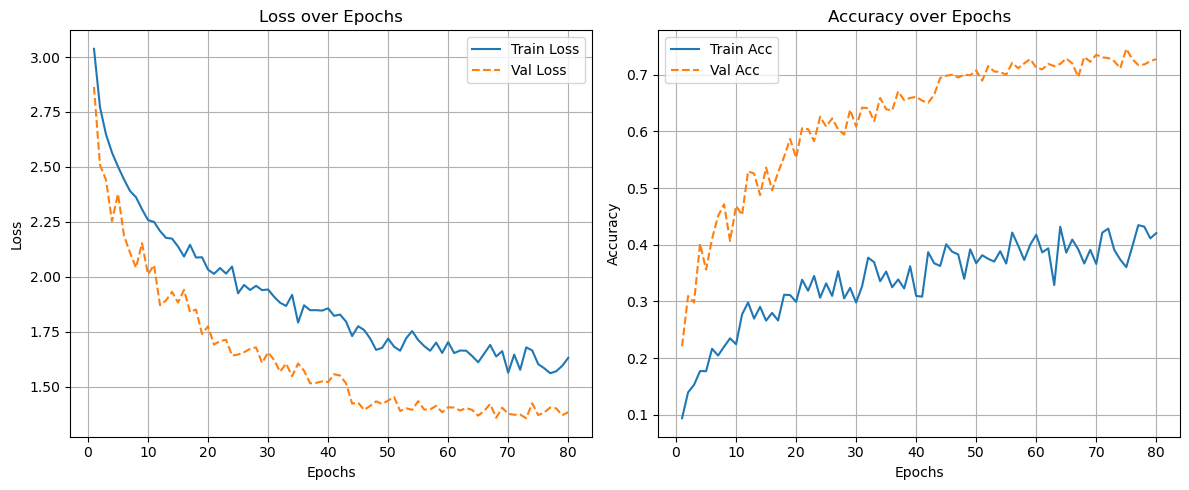

In [71]:
plot_history(history_ResNet_MixUp)

Ради эксперимента можно попробовать сделать light MobileNet, добавить DropOut и AdaptiveAvgPool2d

In [72]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)
            ])
        
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
        ])
        
        #SE Block
        layers.append(SEBlock(hidden_dim))

        # Pointwise Convolution 
        layers.extend([
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [73]:
class SlimAdvancedCustomNet(nn.Module):
    def __init__(self, num_clusses=21):
        super().__init__()
        
       
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.block1 = MBConvBlock(in_channels=16, out_channels=16, stride=1, expand_ratio=1)
        self.block2 = MBConvBlock(in_channels=16, out_channels=24, stride=2, expand_ratio=6)

        self.block4 = MBConvBlock(in_channels=24, out_channels=40, stride=2, expand_ratio=6)
        self.block5 = MBConvBlock(in_channels=40, out_channels=40, stride=1, expand_ratio=6)

        self.block7 = MBConvBlock(in_channels=40, out_channels=80, stride=2, expand_ratio=6)
        self.block8 = MBConvBlock(in_channels=80, out_channels=80, stride=1, expand_ratio=6)


        self.block10 = MBConvBlock(in_channels=80, out_channels=112, stride=2, expand_ratio=6)

        self.conv2 = nn.Conv2d(112, 192, kernel_size=1, bias=False) 
        self.bn2 = nn.BatchNorm2d(192)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(192, num_clusses) 
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block7(out)
        out = self.block8(out)
        out = self.block10(out)
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avg_pool(out)
        out = out.flatten(1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [74]:
model_MN = SlimAdvancedCustomNet(num_clusses=21) 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer_MN = torch.optim.AdamW(model_MN.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 80
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_MN, 
    mode='max', 
    factor=0.5, 
    patience=5, 
    verbose=True
)

In [75]:
trained_model_MN, history_MN = train_tiny(
    model=model_MN,
    train_loader=train_loader_tiny, 
    val_loader=val_loader_tiny,    
    criterion=criterion,
    optimizer=optimizer_MN,
    scheduler=scheduler,
    epochs=epochs,
    device=device
)

Epoch 1/80: 100%|██████████| 165/165 [00:28<00:00,  5.79it/s]


Epoch 1: Train Loss: 2.8096, Train Acc: 0.1848, Val Loss: 2.4167, Val Acc: 0.3219
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 2: Train Loss: 2.4513, Train Acc: 0.3104, Val Loss: 2.2737, Val Acc: 0.3552
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 3: Train Loss: 2.2946, Train Acc: 0.3676, Val Loss: 2.1008, Val Acc: 0.4343
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 4: Train Loss: 2.1544, Train Acc: 0.4144, Val Loss: 2.0515, Val Acc: 0.4505
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/80: 100%|██████████| 165/165 [00:28<00:00,  5.80it/s]


Epoch 5: Train Loss: 2.0592, Train Acc: 0.4576, Val Loss: 2.0096, Val Acc: 0.4838
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/80: 100%|██████████| 165/165 [00:28<00:00,  5.80it/s]


Epoch 6: Train Loss: 1.9794, Train Acc: 0.4881, Val Loss: 1.9378, Val Acc: 0.4924
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 7: Train Loss: 1.9130, Train Acc: 0.5110, Val Loss: 1.7758, Val Acc: 0.5571
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 8: Train Loss: 1.8370, Train Acc: 0.5407, Val Loss: 1.7835, Val Acc: 0.5648
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 9: Train Loss: 1.7903, Train Acc: 0.5632, Val Loss: 1.7044, Val Acc: 0.6048
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 10: Train Loss: 1.7386, Train Acc: 0.5837, Val Loss: 1.7172, Val Acc: 0.5857
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 11: Train Loss: 1.7090, Train Acc: 0.5982, Val Loss: 1.6461, Val Acc: 0.6190
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 12: Train Loss: 1.6693, Train Acc: 0.6072, Val Loss: 1.7068, Val Acc: 0.5981
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 13: Train Loss: 1.6401, Train Acc: 0.6250, Val Loss: 1.6357, Val Acc: 0.6257
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 14: Train Loss: 1.6134, Train Acc: 0.6308, Val Loss: 1.6223, Val Acc: 0.6210
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 15: Train Loss: 1.5769, Train Acc: 0.6497, Val Loss: 1.5367, Val Acc: 0.6476
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 16: Train Loss: 1.5649, Train Acc: 0.6508, Val Loss: 1.5740, Val Acc: 0.6448
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 17: Train Loss: 1.5222, Train Acc: 0.6663, Val Loss: 1.5614, Val Acc: 0.6448
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 18: Train Loss: 1.5207, Train Acc: 0.6716, Val Loss: 1.5086, Val Acc: 0.6676
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 19: Train Loss: 1.5024, Train Acc: 0.6758, Val Loss: 1.5232, Val Acc: 0.6724
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 20: Train Loss: 1.4814, Train Acc: 0.6867, Val Loss: 1.5171, Val Acc: 0.6686
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 21: Train Loss: 1.4754, Train Acc: 0.6898, Val Loss: 1.5828, Val Acc: 0.6571
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 22: Train Loss: 1.4536, Train Acc: 0.6983, Val Loss: 1.4720, Val Acc: 0.6743
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/80: 100%|██████████| 165/165 [00:27<00:00,  5.92it/s]


Epoch 23: Train Loss: 1.4166, Train Acc: 0.7075, Val Loss: 1.5043, Val Acc: 0.6829
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/80: 100%|██████████| 165/165 [00:27<00:00,  5.92it/s]


Epoch 24: Train Loss: 1.4058, Train Acc: 0.7111, Val Loss: 1.4734, Val Acc: 0.6819
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 25: Train Loss: 1.3853, Train Acc: 0.7216, Val Loss: 1.5210, Val Acc: 0.6600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/80: 100%|██████████| 165/165 [00:28<00:00,  5.78it/s]


Epoch 26: Train Loss: 1.3842, Train Acc: 0.7222, Val Loss: 1.4461, Val Acc: 0.7010
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/80: 100%|██████████| 165/165 [00:28<00:00,  5.74it/s]


Epoch 27: Train Loss: 1.3570, Train Acc: 0.7351, Val Loss: 1.4463, Val Acc: 0.6924
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 28: Train Loss: 1.3455, Train Acc: 0.7367, Val Loss: 1.4425, Val Acc: 0.6933
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/80: 100%|██████████| 165/165 [00:28<00:00,  5.86it/s]


Epoch 29: Train Loss: 1.3319, Train Acc: 0.7435, Val Loss: 1.5007, Val Acc: 0.6705
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/80: 100%|██████████| 165/165 [00:28<00:00,  5.87it/s]


Epoch 30: Train Loss: 1.3179, Train Acc: 0.7498, Val Loss: 1.4566, Val Acc: 0.7067
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/80: 100%|██████████| 165/165 [00:28<00:00,  5.86it/s]


Epoch 31: Train Loss: 1.3217, Train Acc: 0.7462, Val Loss: 1.4368, Val Acc: 0.7038
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/80: 100%|██████████| 165/165 [00:28<00:00,  5.88it/s]


Epoch 32: Train Loss: 1.2814, Train Acc: 0.7646, Val Loss: 1.4206, Val Acc: 0.6981
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/80: 100%|██████████| 165/165 [00:27<00:00,  5.96it/s]


Epoch 33: Train Loss: 1.2791, Train Acc: 0.7666, Val Loss: 1.4195, Val Acc: 0.6962
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 34: Train Loss: 1.2862, Train Acc: 0.7626, Val Loss: 1.4716, Val Acc: 0.6905
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/80: 100%|██████████| 165/165 [00:28<00:00,  5.80it/s]


Epoch 35: Train Loss: 1.2683, Train Acc: 0.7683, Val Loss: 1.4058, Val Acc: 0.7048
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/80: 100%|██████████| 165/165 [00:28<00:00,  5.87it/s]


Epoch 36: Train Loss: 1.2545, Train Acc: 0.7747, Val Loss: 1.4695, Val Acc: 0.6752
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/80: 100%|██████████| 165/165 [00:27<00:00,  6.05it/s]


Epoch 37: Train Loss: 1.1774, Train Acc: 0.8078, Val Loss: 1.3690, Val Acc: 0.7248
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 38: Train Loss: 1.1482, Train Acc: 0.8186, Val Loss: 1.3428, Val Acc: 0.7314
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/80: 100%|██████████| 165/165 [00:27<00:00,  5.99it/s]


Epoch 39: Train Loss: 1.1229, Train Acc: 0.8275, Val Loss: 1.3779, Val Acc: 0.7200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 40: Train Loss: 1.1298, Train Acc: 0.8249, Val Loss: 1.3720, Val Acc: 0.7295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 41/80: 100%|██████████| 165/165 [00:27<00:00,  6.04it/s]


Epoch 41: Train Loss: 1.1211, Train Acc: 0.8256, Val Loss: 1.3669, Val Acc: 0.7314
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 42/80: 100%|██████████| 165/165 [00:27<00:00,  6.02it/s]


Epoch 42: Train Loss: 1.1200, Train Acc: 0.8269, Val Loss: 1.3559, Val Acc: 0.7238
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 43/80: 100%|██████████| 165/165 [00:27<00:00,  5.91it/s]


Epoch 43: Train Loss: 1.1248, Train Acc: 0.8278, Val Loss: 1.3671, Val Acc: 0.7171
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 44/80: 100%|██████████| 165/165 [00:27<00:00,  5.93it/s]


Epoch 44: Train Loss: 1.1143, Train Acc: 0.8290, Val Loss: 1.3688, Val Acc: 0.7190
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 45/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 45: Train Loss: 1.0718, Train Acc: 0.8527, Val Loss: 1.3273, Val Acc: 0.7429
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 46/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 46: Train Loss: 1.0538, Train Acc: 0.8583, Val Loss: 1.3586, Val Acc: 0.7248
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 47/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 47: Train Loss: 1.0495, Train Acc: 0.8606, Val Loss: 1.3408, Val Acc: 0.7314
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 48/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 48: Train Loss: 1.0398, Train Acc: 0.8671, Val Loss: 1.3449, Val Acc: 0.7257
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 49/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 49: Train Loss: 1.0364, Train Acc: 0.8628, Val Loss: 1.3501, Val Acc: 0.7295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 50/80: 100%|██████████| 165/165 [00:27<00:00,  6.01it/s]


Epoch 50: Train Loss: 1.0381, Train Acc: 0.8616, Val Loss: 1.3438, Val Acc: 0.7400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 51/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 51: Train Loss: 1.0416, Train Acc: 0.8661, Val Loss: 1.3632, Val Acc: 0.7229
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 52/80: 100%|██████████| 165/165 [00:27<00:00,  5.91it/s]


Epoch 52: Train Loss: 1.0141, Train Acc: 0.8776, Val Loss: 1.3534, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 53/80: 100%|██████████| 165/165 [00:27<00:00,  6.01it/s]


Epoch 53: Train Loss: 1.0010, Train Acc: 0.8802, Val Loss: 1.3392, Val Acc: 0.7333
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 54/80: 100%|██████████| 165/165 [00:27<00:00,  5.96it/s]


Epoch 54: Train Loss: 1.0065, Train Acc: 0.8778, Val Loss: 1.3247, Val Acc: 0.7371
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 55/80: 100%|██████████| 165/165 [00:27<00:00,  5.92it/s]


Epoch 55: Train Loss: 0.9982, Train Acc: 0.8825, Val Loss: 1.3379, Val Acc: 0.7267
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 56/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 56: Train Loss: 0.9930, Train Acc: 0.8838, Val Loss: 1.3334, Val Acc: 0.7381
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 57/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 57: Train Loss: 0.9912, Train Acc: 0.8824, Val Loss: 1.3312, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 58/80: 100%|██████████| 165/165 [00:27<00:00,  5.90it/s]


Epoch 58: Train Loss: 0.9858, Train Acc: 0.8882, Val Loss: 1.3336, Val Acc: 0.7295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 59/80: 100%|██████████| 165/165 [00:28<00:00,  5.87it/s]


Epoch 59: Train Loss: 0.9927, Train Acc: 0.8844, Val Loss: 1.3315, Val Acc: 0.7343
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 60/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 60: Train Loss: 0.9825, Train Acc: 0.8894, Val Loss: 1.3364, Val Acc: 0.7324
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 61/80: 100%|██████████| 165/165 [00:28<00:00,  5.88it/s]


Epoch 61: Train Loss: 0.9804, Train Acc: 0.8888, Val Loss: 1.3225, Val Acc: 0.7419
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 62/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 62: Train Loss: 0.9823, Train Acc: 0.8858, Val Loss: 1.3313, Val Acc: 0.7324
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 63/80: 100%|██████████| 165/165 [00:27<00:00,  5.96it/s]


Epoch 63: Train Loss: 0.9824, Train Acc: 0.8899, Val Loss: 1.3312, Val Acc: 0.7324
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 64/80: 100%|██████████| 165/165 [00:27<00:00,  5.96it/s]


Epoch 64: Train Loss: 0.9751, Train Acc: 0.8890, Val Loss: 1.3309, Val Acc: 0.7390
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 65/80: 100%|██████████| 165/165 [00:28<00:00,  5.87it/s]


Epoch 65: Train Loss: 0.9821, Train Acc: 0.8880, Val Loss: 1.3282, Val Acc: 0.7419
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 66/80: 100%|██████████| 165/165 [00:27<00:00,  5.98it/s]


Epoch 66: Train Loss: 0.9809, Train Acc: 0.8874, Val Loss: 1.3330, Val Acc: 0.7381
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 67/80: 100%|██████████| 165/165 [00:27<00:00,  6.02it/s]


Epoch 67: Train Loss: 0.9636, Train Acc: 0.8970, Val Loss: 1.3320, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 68/80: 100%|██████████| 165/165 [00:27<00:00,  5.93it/s]


Epoch 68: Train Loss: 0.9692, Train Acc: 0.8927, Val Loss: 1.3391, Val Acc: 0.7305
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 69/80: 100%|██████████| 165/165 [00:27<00:00,  5.96it/s]


Epoch 69: Train Loss: 0.9676, Train Acc: 0.8929, Val Loss: 1.3322, Val Acc: 0.7324
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 70/80: 100%|██████████| 165/165 [00:27<00:00,  5.96it/s]


Epoch 70: Train Loss: 0.9700, Train Acc: 0.8922, Val Loss: 1.3356, Val Acc: 0.7314
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 71/80: 100%|██████████| 165/165 [00:27<00:00,  5.94it/s]


Epoch 71: Train Loss: 0.9595, Train Acc: 0.8950, Val Loss: 1.3262, Val Acc: 0.7333
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 72/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 72: Train Loss: 0.9615, Train Acc: 0.8985, Val Loss: 1.3307, Val Acc: 0.7419
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 73/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 73: Train Loss: 0.9557, Train Acc: 0.8998, Val Loss: 1.3304, Val Acc: 0.7352
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 74/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 74: Train Loss: 0.9610, Train Acc: 0.8986, Val Loss: 1.3342, Val Acc: 0.7352
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 75/80: 100%|██████████| 165/165 [00:28<00:00,  5.87it/s]


Epoch 75: Train Loss: 0.9651, Train Acc: 0.8946, Val Loss: 1.3287, Val Acc: 0.7333
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 76/80: 100%|██████████| 165/165 [00:27<00:00,  5.97it/s]


Epoch 76: Train Loss: 0.9707, Train Acc: 0.8927, Val Loss: 1.3278, Val Acc: 0.7352
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 77/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 77: Train Loss: 0.9651, Train Acc: 0.8964, Val Loss: 1.3353, Val Acc: 0.7305
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 78/80: 100%|██████████| 165/165 [00:27<00:00,  5.96it/s]


Epoch 78: Train Loss: 0.9715, Train Acc: 0.8963, Val Loss: 1.3270, Val Acc: 0.7410
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 79/80: 100%|██████████| 165/165 [00:27<00:00,  6.01it/s]


Epoch 79: Train Loss: 0.9561, Train Acc: 0.8968, Val Loss: 1.3352, Val Acc: 0.7276
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 80/80: 100%|██████████| 165/165 [00:27<00:00,  5.99it/s]


Epoch 80: Train Loss: 0.9630, Train Acc: 0.8944, Val Loss: 1.3198, Val Acc: 0.7286
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Итоговые метрики на валидации  
Epoch 80: Train Loss: 0.9630, Train Acc: 0.8944, Val Loss: 1.3198, Val Acc: 0.7286  

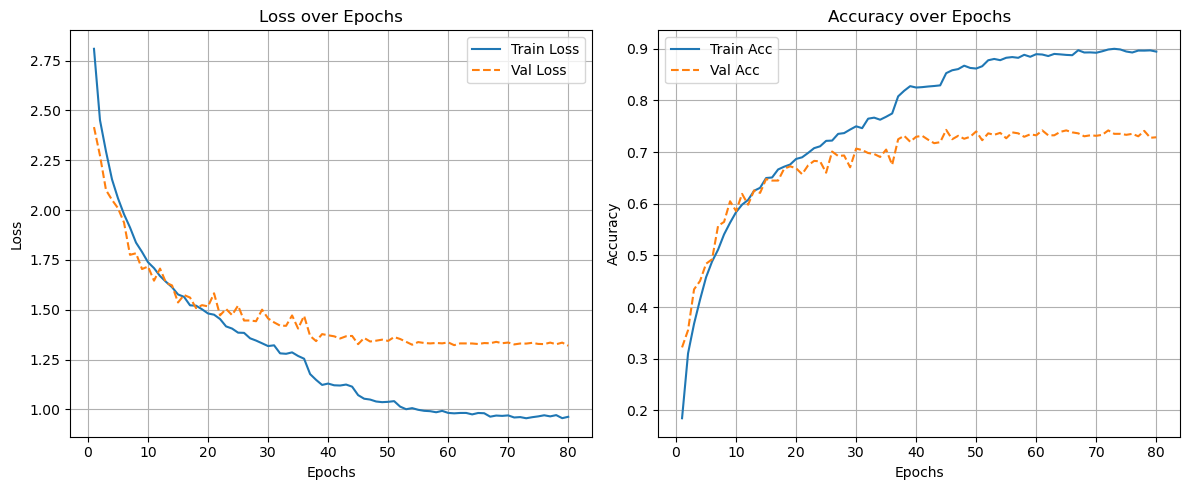

In [76]:
plot_history(history_MN)

После 40й эпохи видно переобучение

In [77]:
model_MN_MixUP = SlimAdvancedCustomNet(num_clusses=21) 
criterion_MixUP = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer_MN_MixUP = torch.optim.AdamW(model_MN_MixUP.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 80
scheduler_MixUP = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_MN_MixUP, 
    mode='max', 
    factor=0.5, 
    patience=5, 
    verbose=True
)

c:\Users\Xenia\anaconda3\envs\cv_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [78]:
trained_model_MN_MixUP, history_MN_MixUP = train_tiny(
    model=model_MN_MixUP,
    train_loader=train_loader_tiny, 
    val_loader=val_loader_tiny,    
    criterion=criterion_MixUP,
    optimizer=optimizer_MN_MixUP,
    scheduler=scheduler_MixUP,
    epochs=epochs,
    device=device,
    use_mixup=True
)

Epoch 1/80: 100%|██████████| 165/165 [00:27<00:00,  5.99it/s]


Epoch 1: Train Loss: 2.8831, Train Acc: 0.1167, Val Loss: 2.5651, Val Acc: 0.2600
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 2: Train Loss: 2.6190, Train Acc: 0.1726, Val Loss: 2.2853, Val Acc: 0.3486
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/80: 100%|██████████| 165/165 [00:27<00:00,  5.97it/s]


Epoch 3: Train Loss: 2.4701, Train Acc: 0.2257, Val Loss: 2.1486, Val Acc: 0.4133
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/80: 100%|██████████| 165/165 [00:27<00:00,  5.98it/s]


Epoch 4: Train Loss: 2.3520, Train Acc: 0.1979, Val Loss: 2.0100, Val Acc: 0.4657
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/80: 100%|██████████| 165/165 [00:27<00:00,  5.94it/s]


Epoch 5: Train Loss: 2.2960, Train Acc: 0.2417, Val Loss: 1.9934, Val Acc: 0.4714
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/80: 100%|██████████| 165/165 [00:28<00:00,  5.86it/s]


Epoch 6: Train Loss: 2.2295, Train Acc: 0.2592, Val Loss: 1.8779, Val Acc: 0.5152
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/80: 100%|██████████| 165/165 [00:28<00:00,  5.86it/s]


Epoch 7: Train Loss: 2.1550, Train Acc: 0.2810, Val Loss: 1.8660, Val Acc: 0.5248
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 8: Train Loss: 2.0997, Train Acc: 0.2830, Val Loss: 1.9082, Val Acc: 0.5105
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 9: Train Loss: 2.1026, Train Acc: 0.2796, Val Loss: 1.7882, Val Acc: 0.5629
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 10: Train Loss: 2.0409, Train Acc: 0.2949, Val Loss: 1.7236, Val Acc: 0.5886
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 11: Train Loss: 2.0134, Train Acc: 0.3106, Val Loss: 1.6606, Val Acc: 0.6048
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 12: Train Loss: 1.9815, Train Acc: 0.3016, Val Loss: 1.6674, Val Acc: 0.6067
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 13: Train Loss: 1.8990, Train Acc: 0.3382, Val Loss: 1.6621, Val Acc: 0.6038
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 14: Train Loss: 1.9582, Train Acc: 0.3141, Val Loss: 1.6036, Val Acc: 0.6257
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 15: Train Loss: 1.9683, Train Acc: 0.3422, Val Loss: 1.6356, Val Acc: 0.5867
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 16: Train Loss: 1.8414, Train Acc: 0.3231, Val Loss: 1.5804, Val Acc: 0.6381
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 17: Train Loss: 1.8581, Train Acc: 0.3557, Val Loss: 1.6227, Val Acc: 0.6210
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/80: 100%|██████████| 165/165 [00:27<00:00,  5.97it/s]


Epoch 18: Train Loss: 1.8295, Train Acc: 0.3359, Val Loss: 1.5525, Val Acc: 0.6400
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 19: Train Loss: 1.8489, Train Acc: 0.3300, Val Loss: 1.6009, Val Acc: 0.6286
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 20: Train Loss: 1.7699, Train Acc: 0.3148, Val Loss: 1.5347, Val Acc: 0.6581
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/80: 100%|██████████| 165/165 [00:27<00:00,  6.00it/s]


Epoch 21: Train Loss: 1.7936, Train Acc: 0.3731, Val Loss: 1.4931, Val Acc: 0.6714
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/80: 100%|██████████| 165/165 [00:27<00:00,  5.90it/s]


Epoch 22: Train Loss: 1.8064, Train Acc: 0.3786, Val Loss: 1.5054, Val Acc: 0.6648
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 23: Train Loss: 1.7938, Train Acc: 0.3759, Val Loss: 1.5601, Val Acc: 0.6410
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 24: Train Loss: 1.7555, Train Acc: 0.3321, Val Loss: 1.4686, Val Acc: 0.6762
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/80: 100%|██████████| 165/165 [00:27<00:00,  5.93it/s]


Epoch 25: Train Loss: 1.7382, Train Acc: 0.3718, Val Loss: 1.4752, Val Acc: 0.6648
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/80: 100%|██████████| 165/165 [00:27<00:00,  5.95it/s]


Epoch 26: Train Loss: 1.7205, Train Acc: 0.3912, Val Loss: 1.4853, Val Acc: 0.6648
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/80: 100%|██████████| 165/165 [00:27<00:00,  5.93it/s]


Epoch 27: Train Loss: 1.7736, Train Acc: 0.3884, Val Loss: 1.4812, Val Acc: 0.6762
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/80: 100%|██████████| 165/165 [00:27<00:00,  5.94it/s]


Epoch 28: Train Loss: 1.7189, Train Acc: 0.3711, Val Loss: 1.4815, Val Acc: 0.6724
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/80: 100%|██████████| 165/165 [00:27<00:00,  5.95it/s]


Epoch 29: Train Loss: 1.7314, Train Acc: 0.3681, Val Loss: 1.4695, Val Acc: 0.6800
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/80: 100%|██████████| 165/165 [00:27<00:00,  6.01it/s]


Epoch 30: Train Loss: 1.6752, Train Acc: 0.3487, Val Loss: 1.4634, Val Acc: 0.6638
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/80: 100%|██████████| 165/165 [00:27<00:00,  6.02it/s]


Epoch 31: Train Loss: 1.6809, Train Acc: 0.3874, Val Loss: 1.4476, Val Acc: 0.6705
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/80: 100%|██████████| 165/165 [00:27<00:00,  5.97it/s]


Epoch 32: Train Loss: 1.6439, Train Acc: 0.3908, Val Loss: 1.4270, Val Acc: 0.6895
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/80: 100%|██████████| 165/165 [00:27<00:00,  5.93it/s]


Epoch 33: Train Loss: 1.6171, Train Acc: 0.3778, Val Loss: 1.4514, Val Acc: 0.6810
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/80: 100%|██████████| 165/165 [00:27<00:00,  5.97it/s]


Epoch 34: Train Loss: 1.6598, Train Acc: 0.3578, Val Loss: 1.4417, Val Acc: 0.6781
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/80: 100%|██████████| 165/165 [00:27<00:00,  5.94it/s]


Epoch 35: Train Loss: 1.6343, Train Acc: 0.3787, Val Loss: 1.4373, Val Acc: 0.6876
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/80: 100%|██████████| 165/165 [00:27<00:00,  5.91it/s]


Epoch 36: Train Loss: 1.5984, Train Acc: 0.3858, Val Loss: 1.4106, Val Acc: 0.6971
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/80: 100%|██████████| 165/165 [00:27<00:00,  5.95it/s]


Epoch 37: Train Loss: 1.6182, Train Acc: 0.3759, Val Loss: 1.3933, Val Acc: 0.7067
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/80: 100%|██████████| 165/165 [00:27<00:00,  5.91it/s]


Epoch 38: Train Loss: 1.5769, Train Acc: 0.3761, Val Loss: 1.3962, Val Acc: 0.7067
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/80: 100%|██████████| 165/165 [00:27<00:00,  5.95it/s]


Epoch 39: Train Loss: 1.6467, Train Acc: 0.3965, Val Loss: 1.3693, Val Acc: 0.7105
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 40: Train Loss: 1.5629, Train Acc: 0.3894, Val Loss: 1.4314, Val Acc: 0.6924
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 41/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 41: Train Loss: 1.6229, Train Acc: 0.4297, Val Loss: 1.4374, Val Acc: 0.7038
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 42/80: 100%|██████████| 165/165 [00:27<00:00,  6.02it/s]


Epoch 42: Train Loss: 1.6100, Train Acc: 0.3901, Val Loss: 1.3742, Val Acc: 0.7171
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 43/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 43: Train Loss: 1.6236, Train Acc: 0.3929, Val Loss: 1.3849, Val Acc: 0.7095
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 44/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 44: Train Loss: 1.5124, Train Acc: 0.4336, Val Loss: 1.3736, Val Acc: 0.7086
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 45/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 45: Train Loss: 1.5698, Train Acc: 0.4358, Val Loss: 1.3735, Val Acc: 0.7124
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 46/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 46: Train Loss: 1.5700, Train Acc: 0.4376, Val Loss: 1.3729, Val Acc: 0.7133
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 47/80: 100%|██████████| 165/165 [00:27<00:00,  5.99it/s]


Epoch 47: Train Loss: 1.5393, Train Acc: 0.4692, Val Loss: 1.4012, Val Acc: 0.7019
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 48/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 48: Train Loss: 1.5968, Train Acc: 0.4553, Val Loss: 1.3594, Val Acc: 0.7086
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 49/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 49: Train Loss: 1.5118, Train Acc: 0.4201, Val Loss: 1.3253, Val Acc: 0.7305
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 50/80: 100%|██████████| 165/165 [00:28<00:00,  5.81it/s]


Epoch 50: Train Loss: 1.4884, Train Acc: 0.4485, Val Loss: 1.3317, Val Acc: 0.7343
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 51/80: 100%|██████████| 165/165 [00:28<00:00,  5.82it/s]


Epoch 51: Train Loss: 1.5222, Train Acc: 0.4156, Val Loss: 1.3447, Val Acc: 0.7238
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 52/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 52: Train Loss: 1.4983, Train Acc: 0.4340, Val Loss: 1.3462, Val Acc: 0.7305
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 53/80: 100%|██████████| 165/165 [00:27<00:00,  5.96it/s]


Epoch 53: Train Loss: 1.4688, Train Acc: 0.3973, Val Loss: 1.3027, Val Acc: 0.7410
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 54/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 54: Train Loss: 1.5167, Train Acc: 0.4861, Val Loss: 1.3269, Val Acc: 0.7162
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 55/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 55: Train Loss: 1.4794, Train Acc: 0.4089, Val Loss: 1.3232, Val Acc: 0.7286
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 56/80: 100%|██████████| 165/165 [00:27<00:00,  6.04it/s]


Epoch 56: Train Loss: 1.4541, Train Acc: 0.3686, Val Loss: 1.3262, Val Acc: 0.7333
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 57/80: 100%|██████████| 165/165 [00:27<00:00,  6.02it/s]


Epoch 57: Train Loss: 1.3990, Train Acc: 0.4628, Val Loss: 1.3093, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 58/80: 100%|██████████| 165/165 [00:27<00:00,  6.03it/s]


Epoch 58: Train Loss: 1.3856, Train Acc: 0.3963, Val Loss: 1.3376, Val Acc: 0.7257
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 59/80: 100%|██████████| 165/165 [00:27<00:00,  6.04it/s]


Epoch 59: Train Loss: 1.4326, Train Acc: 0.3594, Val Loss: 1.3077, Val Acc: 0.7324
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 60/80: 100%|██████████| 165/165 [00:27<00:00,  6.04it/s]


Epoch 60: Train Loss: 1.3828, Train Acc: 0.4119, Val Loss: 1.2976, Val Acc: 0.7457
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 61/80: 100%|██████████| 165/165 [00:27<00:00,  6.01it/s]


Epoch 61: Train Loss: 1.4297, Train Acc: 0.4741, Val Loss: 1.2832, Val Acc: 0.7410
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 62/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 62: Train Loss: 1.3615, Train Acc: 0.4275, Val Loss: 1.3179, Val Acc: 0.7333
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 63/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 63: Train Loss: 1.3770, Train Acc: 0.4535, Val Loss: 1.2876, Val Acc: 0.7514
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 64/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 64: Train Loss: 1.3998, Train Acc: 0.4782, Val Loss: 1.2918, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 65/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 65: Train Loss: 1.3424, Train Acc: 0.4673, Val Loss: 1.3008, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 66/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 66: Train Loss: 1.3500, Train Acc: 0.4370, Val Loss: 1.3106, Val Acc: 0.7467
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 67/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 67: Train Loss: 1.4357, Train Acc: 0.4868, Val Loss: 1.3250, Val Acc: 0.7362
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 68/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 68: Train Loss: 1.3653, Train Acc: 0.4838, Val Loss: 1.2998, Val Acc: 0.7467
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 69/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 69: Train Loss: 1.3274, Train Acc: 0.4987, Val Loss: 1.2987, Val Acc: 0.7324
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 70/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 70: Train Loss: 1.3742, Train Acc: 0.4236, Val Loss: 1.2937, Val Acc: 0.7438
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 71/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 71: Train Loss: 1.2659, Train Acc: 0.4896, Val Loss: 1.2916, Val Acc: 0.7476
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 72/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 72: Train Loss: 1.3554, Train Acc: 0.4591, Val Loss: 1.2969, Val Acc: 0.7438
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 73/80: 100%|██████████| 165/165 [00:28<00:00,  5.86it/s]


Epoch 73: Train Loss: 1.3763, Train Acc: 0.4560, Val Loss: 1.2976, Val Acc: 0.7486
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 74/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 74: Train Loss: 1.3232, Train Acc: 0.4093, Val Loss: 1.2898, Val Acc: 0.7448
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 75/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 75: Train Loss: 1.3220, Train Acc: 0.4810, Val Loss: 1.2915, Val Acc: 0.7524
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 76/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 76: Train Loss: 1.3487, Train Acc: 0.4979, Val Loss: 1.2826, Val Acc: 0.7467
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 77/80: 100%|██████████| 165/165 [00:28<00:00,  5.85it/s]


Epoch 77: Train Loss: 1.2877, Train Acc: 0.4321, Val Loss: 1.2855, Val Acc: 0.7495
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 78/80: 100%|██████████| 165/165 [00:28<00:00,  5.83it/s]


Epoch 78: Train Loss: 1.3443, Train Acc: 0.4839, Val Loss: 1.2835, Val Acc: 0.7486
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 79/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 79: Train Loss: 1.3840, Train Acc: 0.5135, Val Loss: 1.2960, Val Acc: 0.7438
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 80/80: 100%|██████████| 165/165 [00:28<00:00,  5.84it/s]


Epoch 80: Train Loss: 1.3189, Train Acc: 0.4598, Val Loss: 1.2889, Val Acc: 0.7438
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Итоговые метрики на валидации  
Epoch 80: Train Loss: 1.6309, Train Acc: 0.4206, Val Loss: 1.3842, Val Acc: 0.7276 

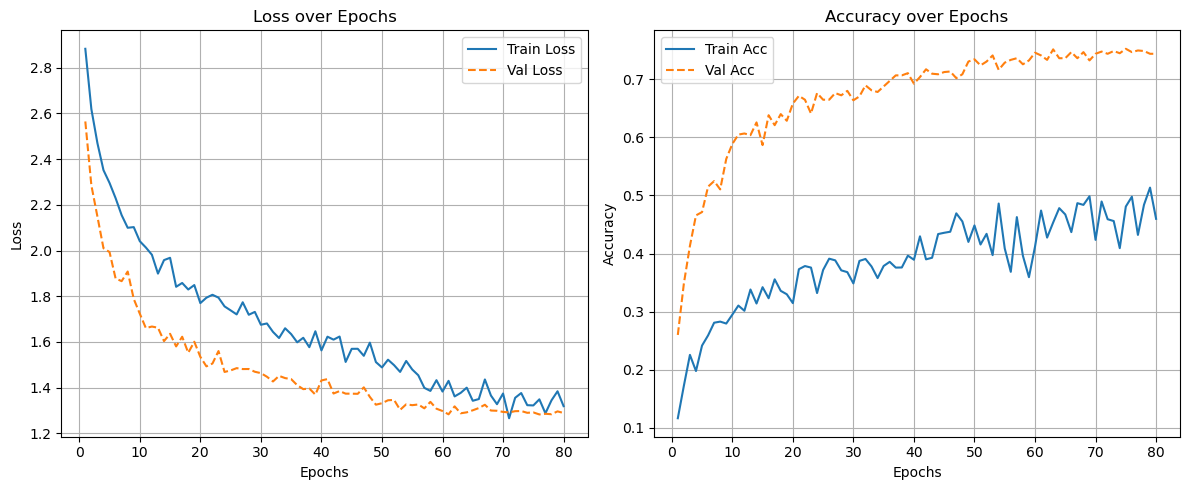

In [79]:
plot_history(history_MN_MixUP)

In [80]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Параметров: {count_parameters(trained_model_MN):,}")

Параметров: 355,253


Сохранение весов лучшей модели ``` trained_model_ResNet - CustomLightNet```

In [120]:
torch.save(trained_model_ResNet.state_dict(), 'tiny_model_trained_model_ResNet.pth')

### Часть 2. Базовая U-Net на "Луне"

Основные компоненты:
* Encoder (Downsampling) - сжимает изображение, извлекая признаки
* Bottleneck - самый глубокий слой с максимальным количеством каналов
* Decoder (Upsampling) - восстанавливает разрешение
* Skip Connections - соединяют encoder и decoder для сохранения деталей

Глубина: 4 уровня down/4 up (энкодер-декодер с skip-связями).

Даунсемплинг: stride 2 или MaxPool.

Итоговый слой: 1 канал с сигмоидой (бинарная сегментация).
Ограничение на количество параметров: до ~2.5M (рекомендуется укладываться, но допускается ±10%).


Вход: 128×128×3

In [82]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1,  bias=False)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1, bias=False)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.down_sample = nn.Identity()
        if in_channels != out_channels or stride != 1:
            self.down_sample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
                
            )

    def forward(self, x):
        identity = x
        if self.down_sample is not None:
            identity = self.down_sample(x)
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu(out)
        # 2 слой
        out = self.conv2(out)
        out = self.batch2(out)
        # должны быть одинаковые размеры
        out += identity
        out = self.relu(out)
        return out

In [83]:
class MoonUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()      
        # ENCODER
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        ) # 3*128*128
        self.layer1 = ResidualBlock(16, 16, stride=1) # 32*128*128
        # stride 2 делает downsampling
        self.layer2 = ResidualBlock(16, 32, stride=2) # 64*64*64
        self.layer3 = ResidualBlock(32, 64, stride=2) # 128*32*32
        self.layer4 = ResidualBlock(64, 128, stride=2) # 256*16*16
        
        # BOTTLENECK
        self.bottleneck = ResidualBlock(128, 256, stride=2) # 512*8*8
        
        # DECODER (Подъем)
        
        # Используем транспонированную свертку для воссатновления
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 256*16*16
        # склейка с ResidualBlock(128, 256, stride=2) # 256*16*16
        # 512 каналов
        self.dec4 = ResidualBlock(256, 128) # 256*16*16
        
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 128*32*32
        # склейка с ResidualBlock(64, 128, stride=2) # 128*32*32
        self.dec3 = ResidualBlock(128, 64) # 128*32*32
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # 64*64*64
        self.dec2 = ResidualBlock(64, 32) # 64*64*64

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) # 32*128*128
        self.dec1 = ResidualBlock(32, 16) # 32*128*128 поднялись
        
        # сжимаем в 1 канал
        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)
    
    def forward(self, x):
        # ENCODER
        x0 = self.initial(x)    

        x1 = self.layer1(x0)      # 128*128
        x2 = self.layer2(x1)      # 64*64
        x3 = self.layer3(x2)      # 32*32
        x4 = self.layer4(x3)      # 16*16
        
        # BOTTLENECK
        code = self.bottleneck(x4) # 8*8
        # DECODER
        up4 = self.up4(code) # 256*16*16
        # x4
        # 512
        cat4 = torch.cat([x4, up4], dim=1) 
        d4 = self.dec4(cat4)

        up3 = self.up3(d4) # 32*32
        cat3 = torch.cat([x3, up3], dim=1)
        d3 = self.dec3(cat3)
        
        up2 = self.up2(d3)
        cat2 = torch.cat([x2, up2], dim=1)
        d2 = self.dec2(cat2)
        
        up1 = self.up1(d2)
        cat1 = torch.cat([x1, up1], dim=1)
        d1 = self.dec1(cat1)
        
        # Получаем логиты (не вероятности)
        logits = self.final_conv(d1)
        return logits

Для расчета метрик. Выход модели без сигмоиды.

In [84]:
def calculate_metrics(logits, targets, threshold=0.5):
    # вероятности
    probs = torch.sigmoid(logits)
    # порог
    preds = (probs > threshold).float()
    targets = targets.float()
    
    # Pixel Accuracy 
    # preds == targets
    correct_pixels = (preds == targets).sum().item()
    total_pixels = torch.numel(preds)
    pixel_acc = correct_pixels / total_pixels
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    
    # Пересечение (True Positive)
    intersection = (preds_flat * targets_flat).sum().item()
    preds_sum = preds_flat.sum().item()
    targets_sum = targets_flat.sum().item()
    # Dice Score (F1)
    # 2 * TP / (2 * TP + FP + FN)
    smooth = 1e-5
    dice = (2. * intersection + smooth) / (preds_sum + targets_sum + smooth)
    #IoU 
    # TP / (TP + FP + FN)
    union = preds_sum + targets_sum - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou, dice, pixel_acc

Обучение

In [85]:
def train_moon(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    model = model.to(device)
    history = {
        'train_loss': [], 
        'train_iou': [], 
        'train_dice': [], 
        'train_acc': [],
        'val_loss': [], 
        'val_iou': [], 
        'val_dice': [], 
        'val_acc': []
    }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_dice = 0.0
        train_acc = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)
            
            # чтобы не было ошибки [4, 1, 128, 128]
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)
            output = model(images)
            loss = criterion(output, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            iou, dice, acc = calculate_metrics(output.detach(), masks.detach())
            train_iou += iou
            train_dice += dice
            train_acc += acc
            

        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)
        
        history['train_loss'].append(avg_train_loss)
        history['train_iou'].append(avg_train_iou)
        history['train_dice'].append(avg_train_dice)
        history['train_acc'].append(avg_train_acc)

        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_dice = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                if masks.ndim == 3:
                    masks = masks.unsqueeze(1)
                output = model(images)
                loss = criterion(output, masks)
                
                val_loss += loss.item()
                iou, dice, acc = calculate_metrics(output, masks)
                val_iou += iou
                val_dice += dice
                val_acc += acc

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)
        history['val_dice'].append(avg_val_dice)
        history['val_acc'].append(avg_val_acc)

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_iou) 
            else:
                scheduler.step()

        print(f"\nResults Epoch {epoch+1}:")
        print(f"Train | Loss: {avg_train_loss:.4f} | IoU: {avg_train_iou:.4f} | Dice: {avg_train_dice:.4f} | Acc: {avg_train_acc:.4f}")
        print(f"Val   | Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f} | Dice: {avg_val_dice:.4f} | Acc: {avg_val_acc:.4f}")
        print(' ^-^ ' * 60)
        
    return model, history

Комбинируем 0.5BCE + 0.5Dice

In [86]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        # BCE Loss
        bce_loss = self.bce(inputs, targets)
        
        # Dice Loss
        inputs_sigmoid = torch.sigmoid(inputs)       
        
        # Flatten (вытягиваем в вектор для подсчета)
        inputs_flat = inputs_sigmoid.view(-1)
        targets_flat = targets.view(-1)
        
        smooth = 1e-5
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        
        # Комбинируем: 0.5 BCE + 0.5 Dice
        return 0.5 * bce_loss + 0.5 * dice_loss

In [87]:
modelMoon = MoonUNet(in_channels=3, out_channels=1)
# модель выдает логиты (без сигмоиды)
criterionMoon = BCEDiceLoss() 
optimizerMoon = torch.optim.AdamW(modelMoon.parameters(), lr=1e-3, weight_decay=1e-4)
schedulerMoon = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizerMoon, mode='max', factor=0.5, patience=3, verbose=True
)
epochs = 40 

c:\Users\Xenia\anaconda3\envs\cv_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Изменим функции логирования

In [129]:
def plot_history_moon(history):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    # Loss 
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

    # IoU
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, history['train_iou'], label='Train IoU')
    plt.plot(epochs_range, history['val_iou'], label='Val IoU', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('IoU (Jaccard)')
    plt.legend()
    plt.grid(True)

    # Dice 
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, history['train_dice'], label='Train Dice')
    plt.plot(epochs_range, history['val_dice'], label='Val Dice', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.title('Dice Score')
    plt.legend()
    plt.grid(True)

    # Pixel Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, history['train_acc'], label='Train Acc')
    plt.plot(epochs_range, history['val_acc'], label='Val Acc', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Pixel Accuracy')
    plt.title('Pixel Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [88]:
trained_model, logs = train_moon(
    model=modelMoon, 
    train_loader=train_loader_moon, 
    val_loader=val_loader_moon, 
    criterion=criterionMoon, 
    optimizer=optimizerMoon, 
    scheduler=schedulerMoon, 
    epochs=epochs,
    device=device
)

Epoch 1/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 1:
Train | Loss: 0.6085 | IoU: 0.3090 | Dice: 0.4680 | Acc: 0.7971
Val   | Loss: 0.5810 | IoU: 0.0348 | Dice: 0.0671 | Acc: 0.8761
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/40: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]



Results Epoch 2:
Train | Loss: 0.5169 | IoU: 0.3689 | Dice: 0.5366 | Acc: 0.8617
Val   | Loss: 0.5231 | IoU: 0.3597 | Dice: 0.5287 | Acc: 0.8309
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/40: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s]



Results Epoch 3:
Train | Loss: 0.4794 | IoU: 0.3831 | Dice: 0.5531 | Acc: 0.8723
Val   | Loss: 0.4425 | IoU: 0.4118 | Dice: 0.5831 | Acc: 0.8991
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/40: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s]



Results Epoch 4:
Train | Loss: 0.4514 | IoU: 0.3935 | Dice: 0.5630 | Acc: 0.8748
Val   | Loss: 0.4132 | IoU: 0.4223 | Dice: 0.5935 | Acc: 0.8971
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 5:
Train | Loss: 0.4265 | IoU: 0.4104 | Dice: 0.5804 | Acc: 0.8834
Val   | Loss: 0.4148 | IoU: 0.4306 | Dice: 0.6018 | Acc: 0.8832
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/40: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s]



Results Epoch 6:
Train | Loss: 0.4111 | IoU: 0.4156 | Dice: 0.5855 | Acc: 0.8872
Val   | Loss: 0.3787 | IoU: 0.4515 | Dice: 0.6219 | Acc: 0.9030
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 7:
Train | Loss: 0.4025 | IoU: 0.4130 | Dice: 0.5831 | Acc: 0.8876
Val   | Loss: 0.4124 | IoU: 0.3920 | Dice: 0.5631 | Acc: 0.8751
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 8:
Train | Loss: 0.3921 | IoU: 0.4233 | Dice: 0.5925 | Acc: 0.8893
Val   | Loss: 0.4098 | IoU: 0.4024 | Dice: 0.5731 | Acc: 0.8672
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/40: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]



Results Epoch 9:
Train | Loss: 0.3839 | IoU: 0.4284 | Dice: 0.5988 | Acc: 0.8923
Val   | Loss: 0.3442 | IoU: 0.4664 | Dice: 0.6358 | Acc: 0.9109
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 10:
Train | Loss: 0.3790 | IoU: 0.4307 | Dice: 0.6008 | Acc: 0.8938
Val   | Loss: 0.3617 | IoU: 0.4459 | Dice: 0.6163 | Acc: 0.9028
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 11:
Train | Loss: 0.3666 | IoU: 0.4439 | Dice: 0.6140 | Acc: 0.8960
Val   | Loss: 0.3935 | IoU: 0.4338 | Dice: 0.6046 | Acc: 0.8758
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/40: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s]



Results Epoch 12:
Train | Loss: 0.3670 | IoU: 0.4444 | Dice: 0.6140 | Acc: 0.8956
Val   | Loss: 0.3450 | IoU: 0.4556 | Dice: 0.6256 | Acc: 0.9046
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 13:
Train | Loss: 0.3571 | IoU: 0.4547 | Dice: 0.6239 | Acc: 0.9006
Val   | Loss: 0.3347 | IoU: 0.4546 | Dice: 0.6247 | Acc: 0.9187
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/40: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s]



Results Epoch 14:
Train | Loss: 0.3405 | IoU: 0.4760 | Dice: 0.6437 | Acc: 0.9034
Val   | Loss: 0.3231 | IoU: 0.4864 | Dice: 0.6542 | Acc: 0.9161
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/40: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s]



Results Epoch 15:
Train | Loss: 0.3475 | IoU: 0.4662 | Dice: 0.6350 | Acc: 0.9039
Val   | Loss: 0.3240 | IoU: 0.4822 | Dice: 0.6504 | Acc: 0.9169
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 16:
Train | Loss: 0.3370 | IoU: 0.4803 | Dice: 0.6481 | Acc: 0.9050
Val   | Loss: 0.3172 | IoU: 0.4886 | Dice: 0.6561 | Acc: 0.9184
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/40: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]



Results Epoch 17:
Train | Loss: 0.3396 | IoU: 0.4757 | Dice: 0.6436 | Acc: 0.9051
Val   | Loss: 0.3259 | IoU: 0.4726 | Dice: 0.6417 | Acc: 0.9157
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/40: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s]



Results Epoch 18:
Train | Loss: 0.3391 | IoU: 0.4748 | Dice: 0.6424 | Acc: 0.9040
Val   | Loss: 0.3216 | IoU: 0.4818 | Dice: 0.6500 | Acc: 0.9142
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/40: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]



Results Epoch 19:
Train | Loss: 0.3297 | IoU: 0.4862 | Dice: 0.6538 | Acc: 0.9069
Val   | Loss: 0.3268 | IoU: 0.4812 | Dice: 0.6494 | Acc: 0.9101
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 20:
Train | Loss: 0.3301 | IoU: 0.4864 | Dice: 0.6531 | Acc: 0.9076
Val   | Loss: 0.3126 | IoU: 0.4929 | Dice: 0.6599 | Acc: 0.9183
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/40: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]



Results Epoch 21:
Train | Loss: 0.3316 | IoU: 0.4848 | Dice: 0.6514 | Acc: 0.9075
Val   | Loss: 0.3161 | IoU: 0.4943 | Dice: 0.6612 | Acc: 0.9145
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 22:
Train | Loss: 0.3316 | IoU: 0.4851 | Dice: 0.6523 | Acc: 0.9065
Val   | Loss: 0.3261 | IoU: 0.4703 | Dice: 0.6394 | Acc: 0.9166
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 23:
Train | Loss: 0.3314 | IoU: 0.4828 | Dice: 0.6498 | Acc: 0.9059
Val   | Loss: 0.3065 | IoU: 0.4981 | Dice: 0.6647 | Acc: 0.9205
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 24:
Train | Loss: 0.3281 | IoU: 0.4876 | Dice: 0.6544 | Acc: 0.9066
Val   | Loss: 0.3310 | IoU: 0.4791 | Dice: 0.6476 | Acc: 0.9053
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 25:
Train | Loss: 0.3302 | IoU: 0.4832 | Dice: 0.6497 | Acc: 0.9079
Val   | Loss: 0.3277 | IoU: 0.4643 | Dice: 0.6336 | Acc: 0.9157
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 26:
Train | Loss: 0.3266 | IoU: 0.4914 | Dice: 0.6575 | Acc: 0.9075
Val   | Loss: 0.3168 | IoU: 0.4952 | Dice: 0.6622 | Acc: 0.9146
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/40: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s]



Results Epoch 27:
Train | Loss: 0.3269 | IoU: 0.4883 | Dice: 0.6551 | Acc: 0.9070
Val   | Loss: 0.3600 | IoU: 0.4411 | Dice: 0.6119 | Acc: 0.8897
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/40: 100%|██████████| 25/25 [00:06<00:00,  3.79it/s]



Results Epoch 28:
Train | Loss: 0.3222 | IoU: 0.4962 | Dice: 0.6617 | Acc: 0.9094
Val   | Loss: 0.3143 | IoU: 0.4883 | Dice: 0.6559 | Acc: 0.9200
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 29:
Train | Loss: 0.3181 | IoU: 0.5005 | Dice: 0.6659 | Acc: 0.9100
Val   | Loss: 0.3056 | IoU: 0.5056 | Dice: 0.6712 | Acc: 0.9184
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 30:
Train | Loss: 0.3114 | IoU: 0.5102 | Dice: 0.6744 | Acc: 0.9132
Val   | Loss: 0.3067 | IoU: 0.4988 | Dice: 0.6653 | Acc: 0.9218
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/40: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]



Results Epoch 31:
Train | Loss: 0.3107 | IoU: 0.5108 | Dice: 0.6752 | Acc: 0.9129
Val   | Loss: 0.3017 | IoU: 0.5066 | Dice: 0.6721 | Acc: 0.9205
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 32:
Train | Loss: 0.3112 | IoU: 0.5088 | Dice: 0.6734 | Acc: 0.9126
Val   | Loss: 0.2976 | IoU: 0.5099 | Dice: 0.6750 | Acc: 0.9219
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 33:
Train | Loss: 0.3065 | IoU: 0.5162 | Dice: 0.6796 | Acc: 0.9140
Val   | Loss: 0.2988 | IoU: 0.5120 | Dice: 0.6768 | Acc: 0.9204
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 34:
Train | Loss: 0.3105 | IoU: 0.5124 | Dice: 0.6764 | Acc: 0.9122
Val   | Loss: 0.3035 | IoU: 0.5096 | Dice: 0.6748 | Acc: 0.9168
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/40: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s]



Results Epoch 35:
Train | Loss: 0.3098 | IoU: 0.5092 | Dice: 0.6738 | Acc: 0.9137
Val   | Loss: 0.3047 | IoU: 0.4972 | Dice: 0.6637 | Acc: 0.9218
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 36:
Train | Loss: 0.3027 | IoU: 0.5207 | Dice: 0.6839 | Acc: 0.9152
Val   | Loss: 0.3090 | IoU: 0.4944 | Dice: 0.6611 | Acc: 0.9216
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/40: 100%|██████████| 25/25 [00:06<00:00,  3.81it/s]



Results Epoch 37:
Train | Loss: 0.3052 | IoU: 0.5181 | Dice: 0.6812 | Acc: 0.9140
Val   | Loss: 0.3013 | IoU: 0.5011 | Dice: 0.6673 | Acc: 0.9232
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/40: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]



Results Epoch 38:
Train | Loss: 0.3063 | IoU: 0.5139 | Dice: 0.6776 | Acc: 0.9150
Val   | Loss: 0.2978 | IoU: 0.5090 | Dice: 0.6743 | Acc: 0.9215
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 39:
Train | Loss: 0.3011 | IoU: 0.5217 | Dice: 0.6848 | Acc: 0.9162
Val   | Loss: 0.2963 | IoU: 0.5129 | Dice: 0.6776 | Acc: 0.9218
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/40: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s]



Results Epoch 40:
Train | Loss: 0.2975 | IoU: 0.5278 | Dice: 0.6903 | Acc: 0.9168
Val   | Loss: 0.2981 | IoU: 0.5118 | Dice: 0.6767 | Acc: 0.9210
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


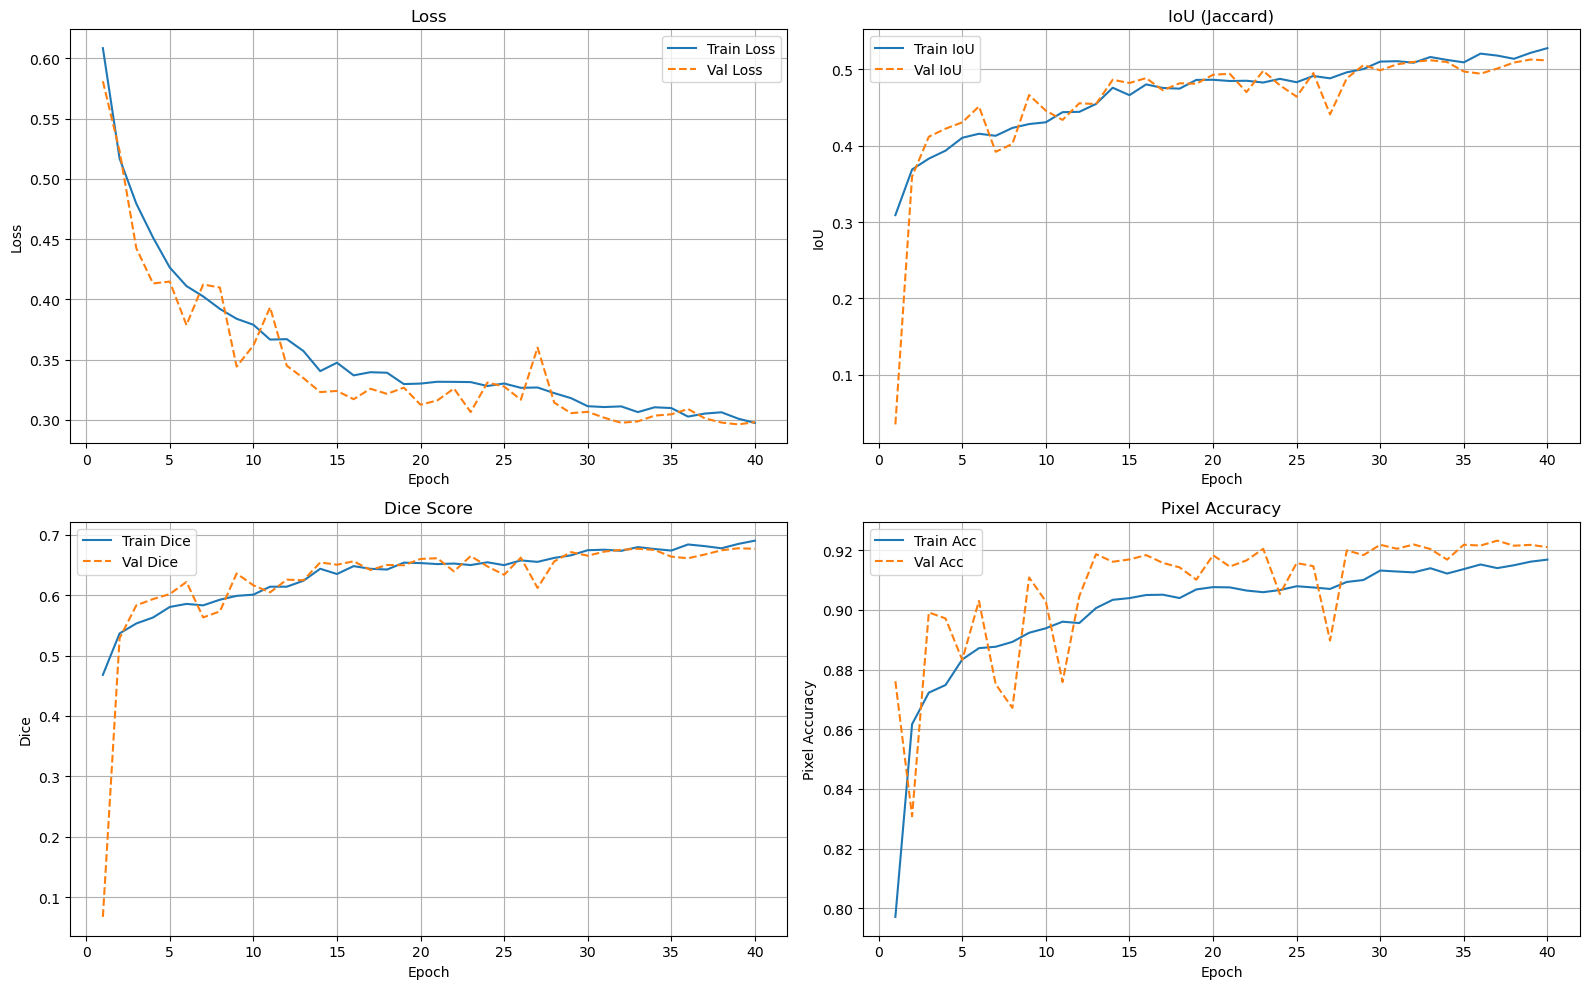

In [130]:
plot_history_moon(logs)

Итоговые метрики  
Epoch 40:  
Train: Loss: 0.2975, IoU: 0.5278, Dice: 0.6903, Acc: 0.9168  
Val: Loss: 0.2981, IoU: 0.5118, Dice: 0.6767, Acc: 0.9210
 

Модель захватывает только около половины площади кратеров  или имеет значительные неточности по границам. Можно попробовать изменить архитектуру модели (увеличить количество каналов).

Визуализация

In [127]:
def visualize_moon_segmentation(model, dataloader, device, num_visualizations=5, threshold=0.5):
    model.eval()
    visualizations_done = 0
    fig, axes = plt.subplots(num_visualizations, 3, figsize=(12, 4 * num_visualizations))
    axes[0, 0].set_title('Входное изображение', fontsize=14)
    axes[0, 1].set_title(f'Предсказанная маска (Porog={threshold})', fontsize=14)
    axes[0, 2].set_title('GT маска (Истина)', fontsize=14)

    with torch.no_grad():
        for images, masks in dataloader:
            if visualizations_done >= num_visualizations:
                break
                
            images, masks = images.to(device), masks.to(device)
            if masks.ndim == 3:
                masks = masks.unsqueeze(1)
            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
            
            # Переводим в NumPy для отрисовки (берем только первое изображение из батча)
            for i in range(images.size(0)):
                if visualizations_done >= num_visualizations:
                    break
                img_np = images[i].cpu().numpy().transpose(1, 2, 0)
                pred_mask_np = preds[i].squeeze().cpu().numpy()
                gt_mask_np = masks[i].squeeze().cpu().numpy()

                row = visualizations_done
                axes[row, 0].imshow(img_np) 
                axes[row, 0].axis('off')
                axes[row, 1].imshow(pred_mask_np, cmap='binary') # 'binary' для бинарных масок
                axes[row, 1].axis('off')
                axes[row, 2].imshow(gt_mask_np, cmap='binary')
                axes[row, 2].axis('off')
                
                visualizations_done += 1

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.012549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.04305013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.012549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776906].


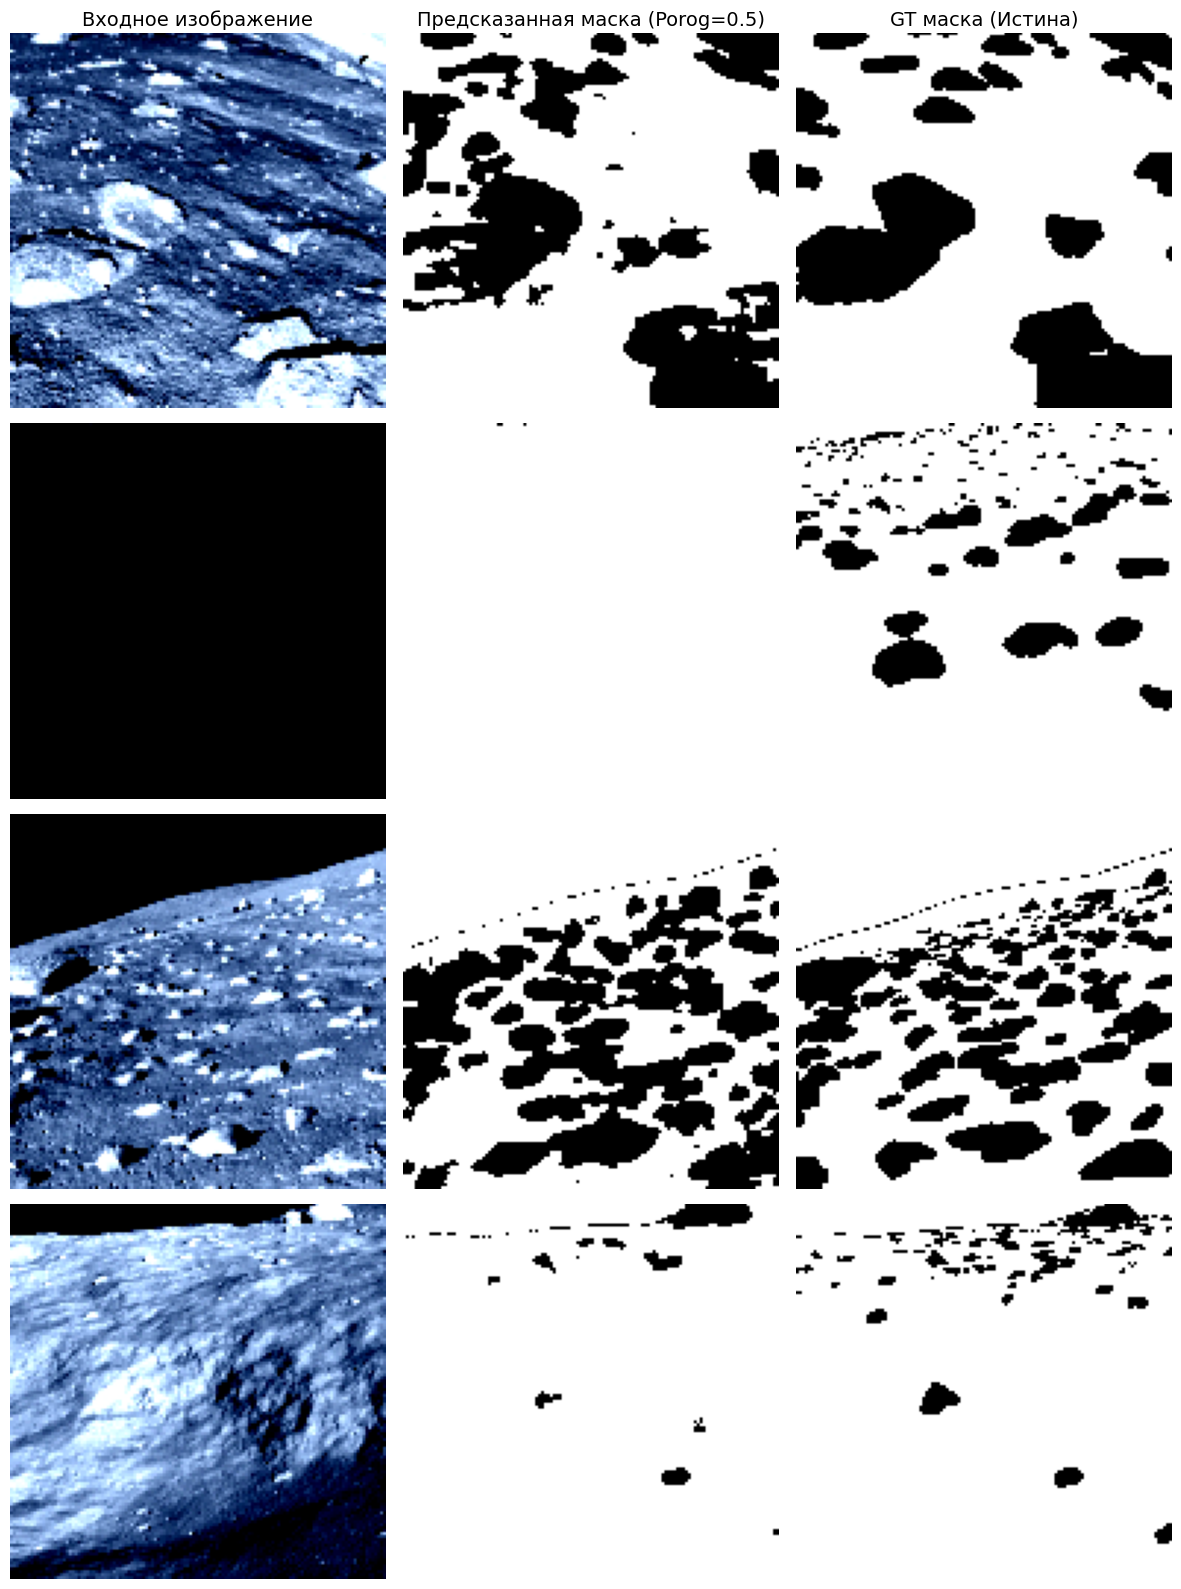

In [128]:
visualize_moon_segmentation(
    model=trained_model, 
    dataloader=val_loader_moon, 
    device=device, 
    num_visualizations=4
)

Просто эксперимент, данная модель ~3М параметров, что не укладывается в лимиты задания

In [89]:
class MoonUNetLarge(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        ) 
        
        self.layer1 = ResidualBlock(16, 16, stride=1) 
        # stride 2 делает downsampling
        self.layer2 = ResidualBlock(16, 32, stride=2) 
        self.layer3 = ResidualBlock(32, 64, stride=2) 
        
        # 160 
        self.layer4 = ResidualBlock(64, 160, stride=2) 
        
        # BOTTLENECK 320
        self.bottleneck = ResidualBlock(160, 320, stride=2) 
        
        self.up4 = nn.ConvTranspose2d(320, 160, kernel_size=2, stride=2) 
        self.dec4 = ResidualBlock(320, 160) 
    
        self.up3 = nn.ConvTranspose2d(160, 64, kernel_size=2, stride=2) 
  
        self.dec3 = ResidualBlock(128, 64)
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) 
        self.dec2 = ResidualBlock(64, 32)

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = ResidualBlock(32, 16)

        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)
    
    def forward(self, x):
        # ENCODER
        x0 = self.initial(x) 

        x1 = self.layer1(x0)
        x2 = self.layer2(x1) 
        x3 = self.layer3(x2) 
        x4 = self.layer4(x3) 
        
        # BOTTLENECK
        code = self.bottleneck(x4) # 320 каналов
        
        # DECODER
        up4 = self.up4(code)       # 160 каналов
        cat4 = torch.cat([x4, up4], dim=1) # 160 + 160 = 320
        d4 = self.dec4(cat4)       # 160 каналов

        up3 = self.up3(d4)         # 64 канала
        cat3 = torch.cat([x3, up3], dim=1) # 64 + 64 = 128
        d3 = self.dec3(cat3)       # 64 канала
        
        up2 = self.up2(d3)
        cat2 = torch.cat([x2, up2], dim=1) # 32 + 32 = 64
        d2 = self.dec2(cat2)       # 32 канала
        
        up1 = self.up1(d2)
        cat1 = torch.cat([x1, up1], dim=1) # 16 + 16 = 32
        d1 = self.dec1(cat1)       # 16 каналов
        
        # Получаем логиты (не вероятности)
        logits = self.final_conv(d1)
        return logits

In [90]:
modelMoonLarge = MoonUNetLarge(in_channels=3, out_channels=1)
# модель выдает логиты (без сигмоиды)
criterionMoonLarge = BCEDiceLoss() 
optimizerMoonLarge = torch.optim.AdamW(modelMoonLarge.parameters(), lr=1e-3, weight_decay=1e-3)
schedulerMoonLarge = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizerMoonLarge, mode='max', factor=0.5, patience=3, verbose=True
)
epochs = 40 

In [91]:
trained_model_ML, history_ML = train_moon(
    model=modelMoonLarge, 
    train_loader=train_loader_moon, 
    val_loader=val_loader_moon, 
    criterion=criterionMoonLarge, 
    optimizer=optimizerMoonLarge, 
    scheduler=schedulerMoonLarge, 
    epochs=epochs,
    device=device
)

Epoch 1/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 1:
Train | Loss: 0.6177 | IoU: 0.2842 | Dice: 0.4381 | Acc: 0.7936
Val   | Loss: 0.5989 | IoU: 0.0561 | Dice: 0.1059 | Acc: 0.8765
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/40: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s]



Results Epoch 2:
Train | Loss: 0.5167 | IoU: 0.3602 | Dice: 0.5279 | Acc: 0.8604
Val   | Loss: 0.4647 | IoU: 0.4050 | Dice: 0.5761 | Acc: 0.9020
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 3:
Train | Loss: 0.4768 | IoU: 0.3822 | Dice: 0.5517 | Acc: 0.8703
Val   | Loss: 0.4516 | IoU: 0.3971 | Dice: 0.5682 | Acc: 0.8741
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/40: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 4:
Train | Loss: 0.4390 | IoU: 0.4089 | Dice: 0.5786 | Acc: 0.8808
Val   | Loss: 0.4102 | IoU: 0.4325 | Dice: 0.6036 | Acc: 0.8903
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 5:
Train | Loss: 0.4164 | IoU: 0.4155 | Dice: 0.5859 | Acc: 0.8843
Val   | Loss: 0.3829 | IoU: 0.4484 | Dice: 0.6189 | Acc: 0.9006
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 6:
Train | Loss: 0.3973 | IoU: 0.4280 | Dice: 0.5982 | Acc: 0.8897
Val   | Loss: 0.3905 | IoU: 0.4377 | Dice: 0.6088 | Acc: 0.8869
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 7:
Train | Loss: 0.3944 | IoU: 0.4202 | Dice: 0.5904 | Acc: 0.8894
Val   | Loss: 0.3717 | IoU: 0.4507 | Dice: 0.6212 | Acc: 0.9022
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/40: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s]



Results Epoch 8:
Train | Loss: 0.3857 | IoU: 0.4269 | Dice: 0.5971 | Acc: 0.8918
Val   | Loss: 0.4044 | IoU: 0.4181 | Dice: 0.5894 | Acc: 0.8663
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 9:
Train | Loss: 0.3738 | IoU: 0.4400 | Dice: 0.6095 | Acc: 0.8958
Val   | Loss: 0.3599 | IoU: 0.4397 | Dice: 0.6104 | Acc: 0.9086
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/40: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]



Results Epoch 10:
Train | Loss: 0.3862 | IoU: 0.4214 | Dice: 0.5911 | Acc: 0.8902
Val   | Loss: 0.3490 | IoU: 0.4551 | Dice: 0.6252 | Acc: 0.9109
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/40: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]



Results Epoch 11:
Train | Loss: 0.3707 | IoU: 0.4372 | Dice: 0.6066 | Acc: 0.8955
Val   | Loss: 0.3514 | IoU: 0.4630 | Dice: 0.6327 | Acc: 0.8956
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 12:
Train | Loss: 0.3576 | IoU: 0.4550 | Dice: 0.6246 | Acc: 0.8996
Val   | Loss: 0.3550 | IoU: 0.4222 | Dice: 0.5932 | Acc: 0.9166
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/40: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 13:
Train | Loss: 0.3618 | IoU: 0.4493 | Dice: 0.6177 | Acc: 0.8983
Val   | Loss: 0.3407 | IoU: 0.4602 | Dice: 0.6298 | Acc: 0.9105
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/40: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 14:
Train | Loss: 0.3593 | IoU: 0.4508 | Dice: 0.6194 | Acc: 0.8987
Val   | Loss: 0.3325 | IoU: 0.4743 | Dice: 0.6431 | Acc: 0.9053
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/40: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s]



Results Epoch 15:
Train | Loss: 0.3518 | IoU: 0.4593 | Dice: 0.6285 | Acc: 0.9011
Val   | Loss: 0.3462 | IoU: 0.4565 | Dice: 0.6263 | Acc: 0.9051
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 16:
Train | Loss: 0.3462 | IoU: 0.4689 | Dice: 0.6367 | Acc: 0.9013
Val   | Loss: 0.3197 | IoU: 0.4851 | Dice: 0.6526 | Acc: 0.9162
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/40: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s]



Results Epoch 17:
Train | Loss: 0.3552 | IoU: 0.4558 | Dice: 0.6252 | Acc: 0.9006
Val   | Loss: 0.3465 | IoU: 0.4430 | Dice: 0.6135 | Acc: 0.9166
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/40: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 18:
Train | Loss: 0.3462 | IoU: 0.4636 | Dice: 0.6321 | Acc: 0.9031
Val   | Loss: 0.3149 | IoU: 0.4949 | Dice: 0.6618 | Acc: 0.9166
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/40: 100%|██████████| 25/25 [00:06<00:00,  3.72it/s]



Results Epoch 19:
Train | Loss: 0.3402 | IoU: 0.4729 | Dice: 0.6415 | Acc: 0.9034
Val   | Loss: 0.3932 | IoU: 0.4304 | Dice: 0.6015 | Acc: 0.8774
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/40: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]



Results Epoch 20:
Train | Loss: 0.3353 | IoU: 0.4794 | Dice: 0.6471 | Acc: 0.9066
Val   | Loss: 0.3231 | IoU: 0.4746 | Dice: 0.6434 | Acc: 0.9174
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 21:
Train | Loss: 0.3341 | IoU: 0.4818 | Dice: 0.6489 | Acc: 0.9052
Val   | Loss: 0.3169 | IoU: 0.4932 | Dice: 0.6602 | Acc: 0.9121
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 22:
Train | Loss: 0.3420 | IoU: 0.4702 | Dice: 0.6382 | Acc: 0.9025
Val   | Loss: 0.3127 | IoU: 0.4879 | Dice: 0.6553 | Acc: 0.9197
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 23:
Train | Loss: 0.3287 | IoU: 0.4858 | Dice: 0.6525 | Acc: 0.9087
Val   | Loss: 0.3108 | IoU: 0.4946 | Dice: 0.6614 | Acc: 0.9184
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 24:
Train | Loss: 0.3255 | IoU: 0.4929 | Dice: 0.6590 | Acc: 0.9071
Val   | Loss: 0.3048 | IoU: 0.5018 | Dice: 0.6679 | Acc: 0.9193
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 25:
Train | Loss: 0.3194 | IoU: 0.4992 | Dice: 0.6647 | Acc: 0.9112
Val   | Loss: 0.3107 | IoU: 0.4887 | Dice: 0.6562 | Acc: 0.9223
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 26:
Train | Loss: 0.3184 | IoU: 0.5004 | Dice: 0.6660 | Acc: 0.9103
Val   | Loss: 0.2985 | IoU: 0.5124 | Dice: 0.6773 | Acc: 0.9215
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 27:
Train | Loss: 0.3156 | IoU: 0.5030 | Dice: 0.6679 | Acc: 0.9124
Val   | Loss: 0.3043 | IoU: 0.5116 | Dice: 0.6764 | Acc: 0.9156
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 28:
Train | Loss: 0.3176 | IoU: 0.5006 | Dice: 0.6663 | Acc: 0.9102
Val   | Loss: 0.3052 | IoU: 0.4999 | Dice: 0.6663 | Acc: 0.9201
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 29:
Train | Loss: 0.3174 | IoU: 0.5024 | Dice: 0.6677 | Acc: 0.9113
Val   | Loss: 0.3030 | IoU: 0.5072 | Dice: 0.6728 | Acc: 0.9177
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 30:
Train | Loss: 0.3110 | IoU: 0.5099 | Dice: 0.6742 | Acc: 0.9139
Val   | Loss: 0.3217 | IoU: 0.4685 | Dice: 0.6378 | Acc: 0.9202
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/40: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]



Results Epoch 31:
Train | Loss: 0.3071 | IoU: 0.5172 | Dice: 0.6811 | Acc: 0.9129
Val   | Loss: 0.3067 | IoU: 0.4967 | Dice: 0.6633 | Acc: 0.9215
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/40: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]



Results Epoch 32:
Train | Loss: 0.3132 | IoU: 0.5042 | Dice: 0.6693 | Acc: 0.9124
Val   | Loss: 0.2995 | IoU: 0.5095 | Dice: 0.6746 | Acc: 0.9215
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 33:
Train | Loss: 0.3052 | IoU: 0.5164 | Dice: 0.6796 | Acc: 0.9149
Val   | Loss: 0.2959 | IoU: 0.5127 | Dice: 0.6775 | Acc: 0.9234
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 34:
Train | Loss: 0.3058 | IoU: 0.5177 | Dice: 0.6809 | Acc: 0.9134
Val   | Loss: 0.3032 | IoU: 0.4991 | Dice: 0.6656 | Acc: 0.9208
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 35:
Train | Loss: 0.3012 | IoU: 0.5216 | Dice: 0.6848 | Acc: 0.9158
Val   | Loss: 0.2978 | IoU: 0.5149 | Dice: 0.6792 | Acc: 0.9206
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/40: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 36:
Train | Loss: 0.3024 | IoU: 0.5209 | Dice: 0.6841 | Acc: 0.9151
Val   | Loss: 0.2987 | IoU: 0.5131 | Dice: 0.6777 | Acc: 0.9201
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 37:
Train | Loss: 0.3039 | IoU: 0.5182 | Dice: 0.6822 | Acc: 0.9162
Val   | Loss: 0.2974 | IoU: 0.5102 | Dice: 0.6753 | Acc: 0.9234
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/40: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]



Results Epoch 38:
Train | Loss: 0.3018 | IoU: 0.5241 | Dice: 0.6864 | Acc: 0.9155
Val   | Loss: 0.2970 | IoU: 0.5146 | Dice: 0.6793 | Acc: 0.9194
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/40: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 39:
Train | Loss: 0.3028 | IoU: 0.5205 | Dice: 0.6840 | Acc: 0.9161
Val   | Loss: 0.2951 | IoU: 0.5153 | Dice: 0.6797 | Acc: 0.9224
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/40: 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]



Results Epoch 40:
Train | Loss: 0.2965 | IoU: 0.5292 | Dice: 0.6909 | Acc: 0.9175
Val   | Loss: 0.2933 | IoU: 0.5159 | Dice: 0.6802 | Acc: 0.9229
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


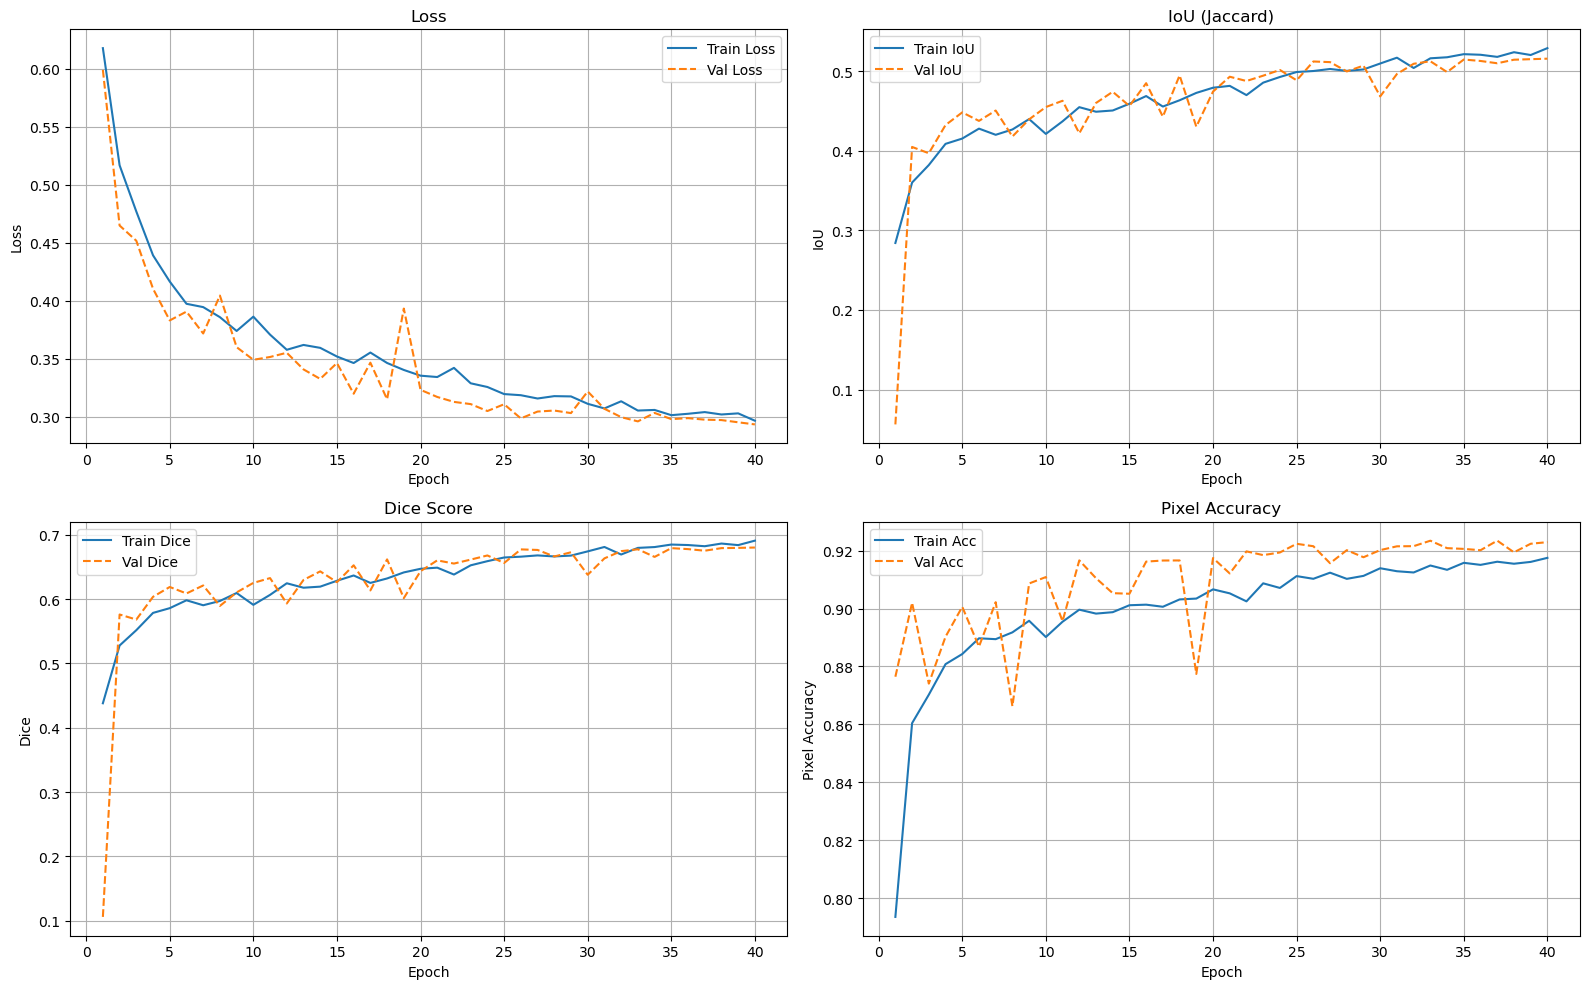

In [131]:
plot_history_moon(history_ML)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.012549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.04305013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.012549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776906].


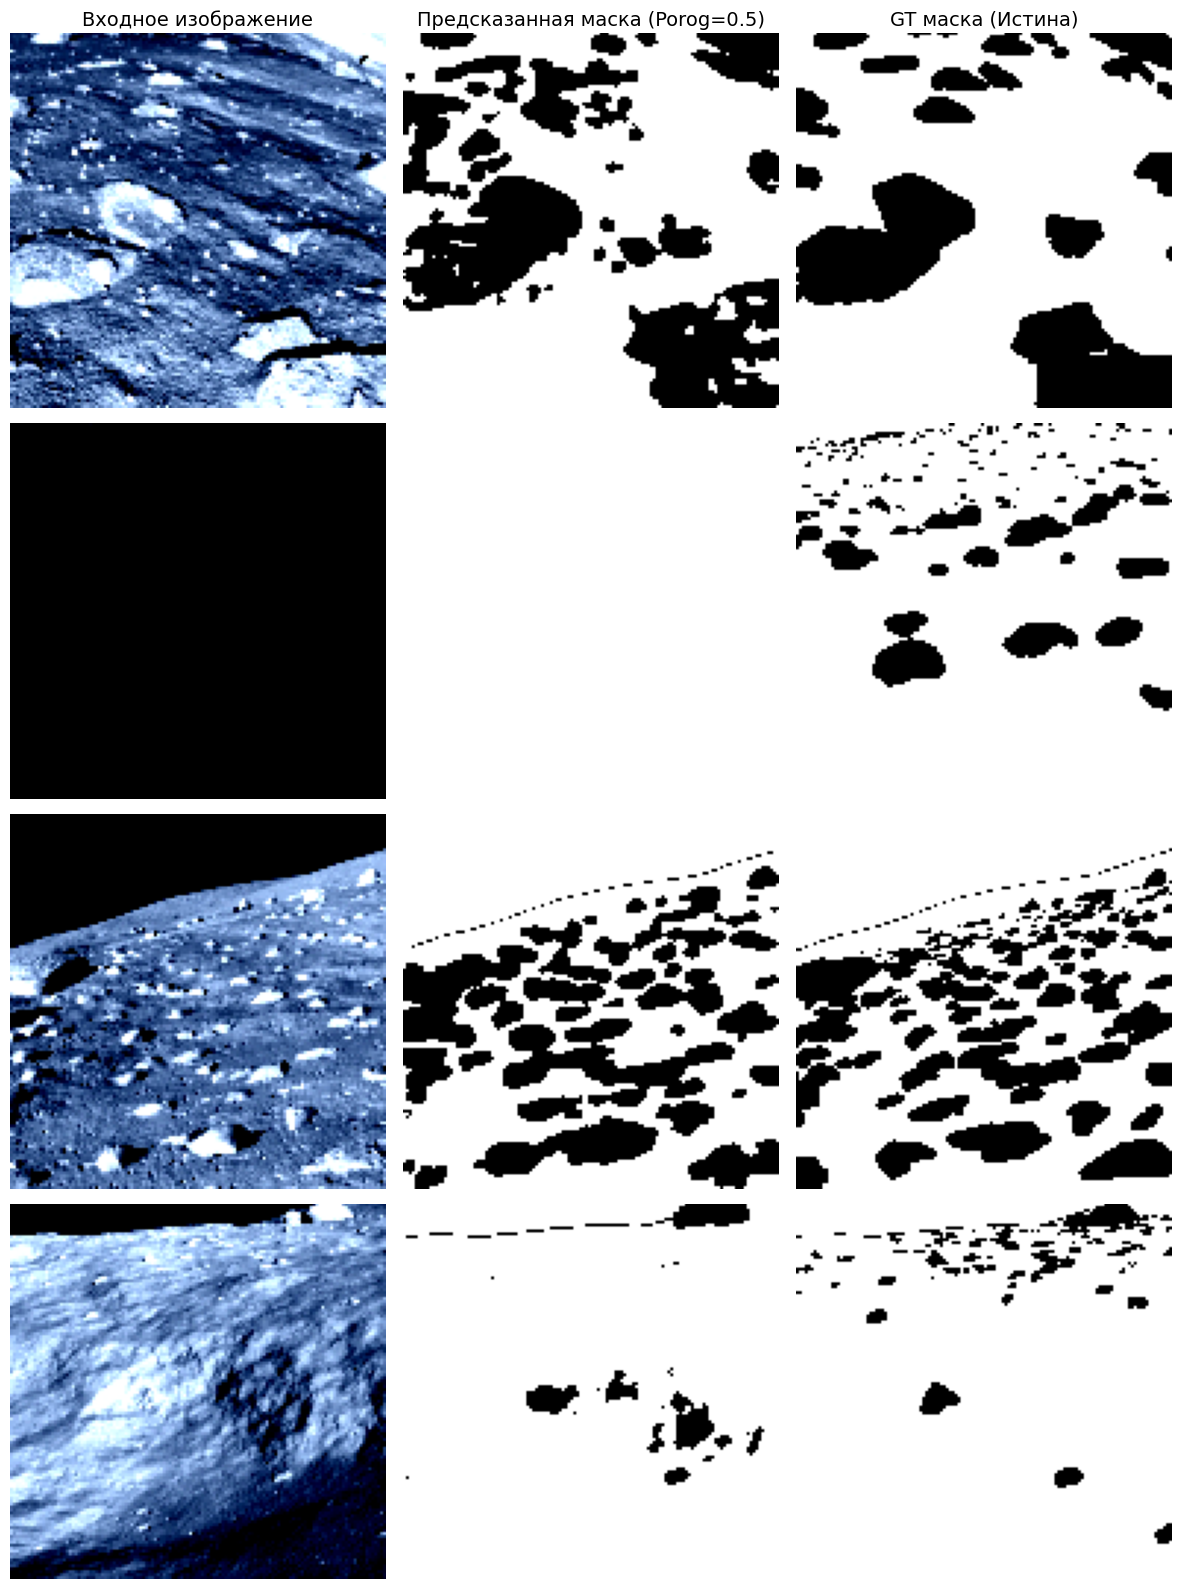

In [132]:
visualize_moon_segmentation(
    model=trained_model_ML, 
    dataloader=val_loader_moon, 
    device=device, 
    num_visualizations=4
)

Pixel Accuracy (Val Acc: 0.9222) показывает долю правильно классифицированных пикселей, где фон (темная поверхность) составляет подавляющее большинство пикселей. Модель может просто очень хорошо предсказывать фон, и эта метрика будет высокой.   

IoU (Val IoU: 0.5375) и Dice (Val Dice: 0.7048) модель захватывает только около половины площади кратеров или имеет значительные неточности по границам.

#### Вывод

Для ```MoonUNet```

In [92]:
print(f"Параметров MoonUNet: {count_parameters(trained_model):,}")

Параметров MoonUNet: 2,033,393


Итоговые метрики на валидации

**Epoch 40**:
* Train: Loss: 0.3192, IoU: 0.5067, Dice: 0.6713, Acc: 0.9120
* Val: Loss: 0.3060, IoU: 0.5083, Dice: 0.6736, Acc: 0.9213
 

Для MoonUNetLarge

In [93]:
print(f"Параметров MoonUNet: {count_parameters(trained_model_ML):,}")

Параметров MoonUNet: 3,002,897


**Epoch 40**:
* Train: Loss: 0.2914, IoU: 0.5375, Dice: 0.6978, Acc: 0.9194
* Val: Loss: 0.2935, IoU: 0.5167, Dice: 0.6811, Acc: 0.9222

### Часть 3. U-Net с бэкбоном из классификатора

Идея: использовать энкодер из вашей модели классификации как бэкбон U‑Net.  
* Вариант A (заморозка): заморозить веса энкодера, обучать только декодер.
* Вариант B (тонкая настройка): полностью разморозить энкодер на поздних этапах.
* Если у классификатора есть GAP/FC-голова — удалите её; возьмите сверточные блоки до глобального усреднения как энкодерные стадии.   
Ограничения и замечания:
* Если количество стадий не совпадает, добавьте адаптационные 1×1 свёртки и интерполяции/пулинг, но опишите это.

Берем ```CustomLightNet``` (он же был энкодером в Unet) и убираем последний полносвязный слой и GAP, также возвращаем все фичи, которые будут использованы в Unet вместе с декодером. Немного изменем класс Unet по сравнению с предыдущим пунктом. Вынесем энкодер в отдельный класс

In [97]:
class CustomEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.LeakyReLU(inplace=True)
        self.basic1 = ResidualBlock(16, 16)
        self.basic2 = ResidualBlock(16, 16) 

        self.basic3 = ResidualBlock(16, 32, stride=2)
        self.basic4 = ResidualBlock(32, 32, stride=1) 

        self.basic5 = ResidualBlock(32, 64, stride=2)
        self.basic6 = ResidualBlock(64, 64, stride=1) 

        self.basic7 = ResidualBlock(64, 128, stride=2)
        self.basic8 = ResidualBlock(128, 128, stride=1) 

        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x0 = self.relu(self.bn1(self.conv1(x)))  # 16 × 128 × 128

        x1 = self.basic2(self.basic1(x0))        # 16 × 128 × 128
        x2 = self.basic4(self.basic3(x1))        # 32 × 64 × 64
        x3 = self.basic6(self.basic5(x2))        # 64 × 32 × 32
        x4 = self.basic8(self.basic7(x3))        # 128 × 16 × 16

        return x1, x2, x3, x4

In [98]:
class MoonUNetBackbone(nn.Module):
    def __init__(self, encoder, out_channels=1):
        super().__init__()      
        # ENCODER
        self.encoder = encoder
        # BOTTLENECK сейчас тут не будет downsampling
        self.bottleneck = ResidualBlock(128, 128, stride=1)
        
        # DECODER (Подъем)
        
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 128*32*32
        # склейка с ResidualBlock(64, 128, stride=2) # 128*32*32
        self.dec3 = ResidualBlock(128, 64) # 128*32*32
        
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) # 64*64*64
        self.dec2 = ResidualBlock(64, 32) # 64*64*64

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) # 32*128*128
        self.dec1 = ResidualBlock(32, 16) # 32*128*128 поднялись
        
        # сжимаем в 1 канал
        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)
    
    def forward(self, x):
        # ENCODER
        x1, x2, x3, x4 = self.encoder(x)
        # x0 = self.initial(x)    

        # x1 = self.layer1(x0)      # 128*128
        # x2 = self.layer2(x1)      # 64*64
        # x3 = self.layer3(x2)      # 32*32
        # x4 = self.layer4(x3)      # 16*16
        
        # BOTTLENECK
        code = self.bottleneck(x4) # 8*8
        # DECODER

        up3 = self.up3(code) # 32*32
        cat3 = torch.cat([x3, up3], dim=1)
        d3 = self.dec3(cat3)
        
        up2 = self.up2(d3)
        cat2 = torch.cat([x2, up2], dim=1)
        d2 = self.dec2(cat2)
        
        up1 = self.up1(d2)
        cat1 = torch.cat([x1, up1], dim=1)
        d1 = self.dec1(cat1)
        
        # Получаем логиты (не вероятности)
        logits = self.final_conv(d1)
        return logits

Веса для энкодера

In [100]:
encoder = CustomEncoder()


In [ ]:
state_dict = torch.load(
    "tiny_model_trained_model_ResNet.pth",
    map_location=device
)

encoder.load_state_dict(state_dict, strict=False)


C:\Users\Xenia\AppData\Local\Temp\ipykernel_22240\3346766406.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])

Вариант A (заморозка): заморозить веса энкодера, обучать только декодер

In [102]:
for p in encoder.parameters():
    p.requires_grad = False


In [103]:
modelA = MoonUNetBackbone(encoder, out_channels=1)
modelA = modelA.to(device)
criterion = BCEDiceLoss()
optimizerA = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, modelA.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

schedulerA = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizerA, mode='max', factor=0.5, patience=3, verbose=True
)


In [104]:
modelA, historyA = train_moon(
    model=modelA,
    train_loader=train_loader_moon,
    val_loader=val_loader_moon,
    criterion=criterion,
    optimizer=optimizerA,
    scheduler=schedulerA,
    epochs=epochs,
    device=device
)


Epoch 1/40: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]



Results Epoch 1:
Train | Loss: 0.5937 | IoU: 0.2958 | Dice: 0.4510 | Acc: 0.7851
Val   | Loss: 0.5915 | IoU: 0.3134 | Dice: 0.4768 | Acc: 0.7744
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/40: 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]



Results Epoch 2:
Train | Loss: 0.4952 | IoU: 0.3839 | Dice: 0.5539 | Acc: 0.8597
Val   | Loss: 0.4394 | IoU: 0.4201 | Dice: 0.5914 | Acc: 0.9004
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/40: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]



Results Epoch 3:
Train | Loss: 0.4576 | IoU: 0.3941 | Dice: 0.5643 | Acc: 0.8703
Val   | Loss: 0.4244 | IoU: 0.4305 | Dice: 0.6018 | Acc: 0.8902
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 4:
Train | Loss: 0.4320 | IoU: 0.4075 | Dice: 0.5779 | Acc: 0.8792
Val   | Loss: 0.4069 | IoU: 0.4401 | Dice: 0.6111 | Acc: 0.9025
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/40: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]



Results Epoch 5:
Train | Loss: 0.4129 | IoU: 0.4117 | Dice: 0.5823 | Acc: 0.8855
Val   | Loss: 0.3877 | IoU: 0.4260 | Dice: 0.5971 | Acc: 0.9076
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 6:
Train | Loss: 0.3984 | IoU: 0.4199 | Dice: 0.5907 | Acc: 0.8876
Val   | Loss: 0.3760 | IoU: 0.4289 | Dice: 0.6000 | Acc: 0.9062
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/40: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]



Results Epoch 7:
Train | Loss: 0.3907 | IoU: 0.4208 | Dice: 0.5908 | Acc: 0.8911
Val   | Loss: 0.3566 | IoU: 0.4518 | Dice: 0.6223 | Acc: 0.9088
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/40: 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]



Results Epoch 8:
Train | Loss: 0.3812 | IoU: 0.4270 | Dice: 0.5971 | Acc: 0.8931
Val   | Loss: 0.3587 | IoU: 0.4526 | Dice: 0.6230 | Acc: 0.8996
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/40: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 9:
Train | Loss: 0.3715 | IoU: 0.4387 | Dice: 0.6087 | Acc: 0.8940
Val   | Loss: 0.3485 | IoU: 0.4479 | Dice: 0.6186 | Acc: 0.9085
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 10:
Train | Loss: 0.3694 | IoU: 0.4376 | Dice: 0.6080 | Acc: 0.8960
Val   | Loss: 0.3438 | IoU: 0.4636 | Dice: 0.6333 | Acc: 0.9063
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/40: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]



Results Epoch 11:
Train | Loss: 0.3685 | IoU: 0.4359 | Dice: 0.6060 | Acc: 0.8963
Val   | Loss: 0.3486 | IoU: 0.4300 | Dice: 0.6012 | Acc: 0.9154
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/40: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 12:
Train | Loss: 0.3644 | IoU: 0.4413 | Dice: 0.6117 | Acc: 0.8971
Val   | Loss: 0.3376 | IoU: 0.4632 | Dice: 0.6330 | Acc: 0.9075
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/40: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]



Results Epoch 13:
Train | Loss: 0.3609 | IoU: 0.4446 | Dice: 0.6148 | Acc: 0.8977
Val   | Loss: 0.3326 | IoU: 0.4667 | Dice: 0.6363 | Acc: 0.9126
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 14:
Train | Loss: 0.3544 | IoU: 0.4552 | Dice: 0.6246 | Acc: 0.9009
Val   | Loss: 0.3383 | IoU: 0.4679 | Dice: 0.6374 | Acc: 0.9066
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 15:
Train | Loss: 0.3613 | IoU: 0.4471 | Dice: 0.6166 | Acc: 0.8972
Val   | Loss: 0.3417 | IoU: 0.4636 | Dice: 0.6334 | Acc: 0.9023
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 16:
Train | Loss: 0.3524 | IoU: 0.4568 | Dice: 0.6261 | Acc: 0.9017
Val   | Loss: 0.3475 | IoU: 0.4280 | Dice: 0.5993 | Acc: 0.9164
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/40: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 17:
Train | Loss: 0.3523 | IoU: 0.4550 | Dice: 0.6243 | Acc: 0.9002
Val   | Loss: 0.3417 | IoU: 0.4393 | Dice: 0.6100 | Acc: 0.9170
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 18:
Train | Loss: 0.3542 | IoU: 0.4523 | Dice: 0.6221 | Acc: 0.9008
Val   | Loss: 0.3352 | IoU: 0.4499 | Dice: 0.6204 | Acc: 0.9173
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/40: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]



Results Epoch 19:
Train | Loss: 0.3431 | IoU: 0.4663 | Dice: 0.6353 | Acc: 0.9041
Val   | Loss: 0.3217 | IoU: 0.4804 | Dice: 0.6488 | Acc: 0.9153
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 20:
Train | Loss: 0.3462 | IoU: 0.4647 | Dice: 0.6337 | Acc: 0.9026
Val   | Loss: 0.3199 | IoU: 0.4772 | Dice: 0.6459 | Acc: 0.9185
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/40: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]



Results Epoch 21:
Train | Loss: 0.3446 | IoU: 0.4636 | Dice: 0.6326 | Acc: 0.9035
Val   | Loss: 0.3269 | IoU: 0.4793 | Dice: 0.6478 | Acc: 0.9094
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/40: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]



Results Epoch 22:
Train | Loss: 0.3422 | IoU: 0.4684 | Dice: 0.6365 | Acc: 0.9042
Val   | Loss: 0.3254 | IoU: 0.4639 | Dice: 0.6335 | Acc: 0.9191
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/40: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 23:
Train | Loss: 0.3452 | IoU: 0.4659 | Dice: 0.6348 | Acc: 0.9036
Val   | Loss: 0.3345 | IoU: 0.4484 | Dice: 0.6188 | Acc: 0.9190
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/40: 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]



Results Epoch 24:
Train | Loss: 0.3452 | IoU: 0.4637 | Dice: 0.6326 | Acc: 0.9049
Val   | Loss: 0.3183 | IoU: 0.4780 | Dice: 0.6466 | Acc: 0.9195
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 25:
Train | Loss: 0.3347 | IoU: 0.4762 | Dice: 0.6443 | Acc: 0.9070
Val   | Loss: 0.3218 | IoU: 0.4855 | Dice: 0.6534 | Acc: 0.9100
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 26/40: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]



Results Epoch 26:
Train | Loss: 0.3353 | IoU: 0.4793 | Dice: 0.6466 | Acc: 0.9057
Val   | Loss: 0.3194 | IoU: 0.4791 | Dice: 0.6476 | Acc: 0.9178
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 27/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 27:
Train | Loss: 0.3358 | IoU: 0.4748 | Dice: 0.6429 | Acc: 0.9075
Val   | Loss: 0.3173 | IoU: 0.4882 | Dice: 0.6559 | Acc: 0.9140
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 28/40: 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]



Results Epoch 28:
Train | Loss: 0.3319 | IoU: 0.4804 | Dice: 0.6480 | Acc: 0.9081
Val   | Loss: 0.3177 | IoU: 0.4869 | Dice: 0.6547 | Acc: 0.9136
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 29/40: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]



Results Epoch 29:
Train | Loss: 0.3349 | IoU: 0.4784 | Dice: 0.6460 | Acc: 0.9058
Val   | Loss: 0.3174 | IoU: 0.4826 | Dice: 0.6508 | Acc: 0.9179
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 30/40: 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]



Results Epoch 30:
Train | Loss: 0.3269 | IoU: 0.4890 | Dice: 0.6558 | Acc: 0.9086
Val   | Loss: 0.3168 | IoU: 0.4845 | Dice: 0.6525 | Acc: 0.9171
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 31/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 31:
Train | Loss: 0.3252 | IoU: 0.4908 | Dice: 0.6575 | Acc: 0.9093
Val   | Loss: 0.3166 | IoU: 0.4826 | Dice: 0.6508 | Acc: 0.9177
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 32/40: 100%|██████████| 25/25 [00:06<00:00,  3.89it/s]



Results Epoch 32:
Train | Loss: 0.3306 | IoU: 0.4820 | Dice: 0.6490 | Acc: 0.9078
Val   | Loss: 0.3160 | IoU: 0.4850 | Dice: 0.6529 | Acc: 0.9170
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 33/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 33:
Train | Loss: 0.3298 | IoU: 0.4847 | Dice: 0.6517 | Acc: 0.9079
Val   | Loss: 0.3170 | IoU: 0.4777 | Dice: 0.6463 | Acc: 0.9203
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 34/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 34:
Train | Loss: 0.3296 | IoU: 0.4832 | Dice: 0.6507 | Acc: 0.9083
Val   | Loss: 0.3141 | IoU: 0.4862 | Dice: 0.6541 | Acc: 0.9180
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 35/40: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 35:
Train | Loss: 0.3298 | IoU: 0.4830 | Dice: 0.6504 | Acc: 0.9081
Val   | Loss: 0.3130 | IoU: 0.4874 | Dice: 0.6551 | Acc: 0.9197
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 36/40: 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]



Results Epoch 36:
Train | Loss: 0.3270 | IoU: 0.4869 | Dice: 0.6543 | Acc: 0.9095
Val   | Loss: 0.3119 | IoU: 0.4912 | Dice: 0.6586 | Acc: 0.9185
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 37/40: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]



Results Epoch 37:
Train | Loss: 0.3227 | IoU: 0.4951 | Dice: 0.6616 | Acc: 0.9100
Val   | Loss: 0.3118 | IoU: 0.4893 | Dice: 0.6569 | Acc: 0.9195
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 38/40: 100%|██████████| 25/25 [00:06<00:00,  3.89it/s]



Results Epoch 38:
Train | Loss: 0.3219 | IoU: 0.4944 | Dice: 0.6604 | Acc: 0.9111
Val   | Loss: 0.3115 | IoU: 0.4920 | Dice: 0.6593 | Acc: 0.9186
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 39/40: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 39:
Train | Loss: 0.3264 | IoU: 0.4897 | Dice: 0.6563 | Acc: 0.9095
Val   | Loss: 0.3126 | IoU: 0.4865 | Dice: 0.6543 | Acc: 0.9204
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 40/40: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 40:
Train | Loss: 0.3243 | IoU: 0.4911 | Dice: 0.6580 | Acc: 0.9103
Val   | Loss: 0.3119 | IoU: 0.4869 | Dice: 0.6548 | Acc: 0.9206
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Итоговые метрики  
Epoch 40:
* Train: Loss: 0.3243, IoU: 0.4911, Dice: 0.6580, Acc: 0.9103
* Val: Loss: 0.3119, IoU: 0.4869, Dice: 0.6548, Acc: 0.9206

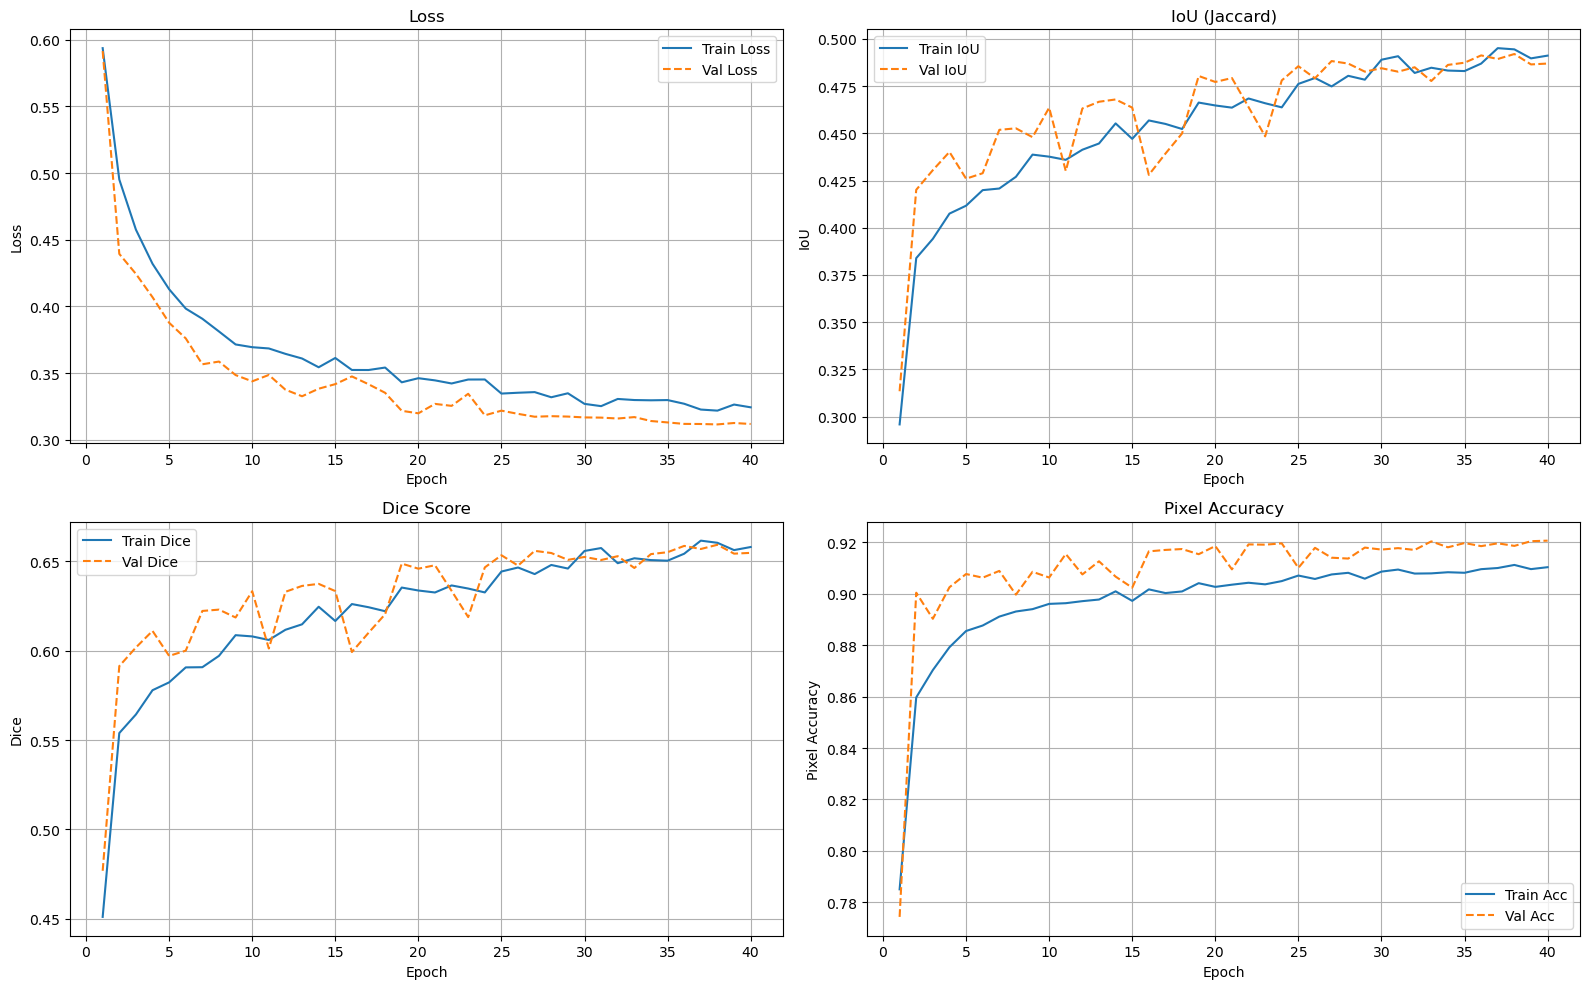

In [133]:
plot_history_moon(historyA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.012549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.04305013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.012549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776906].


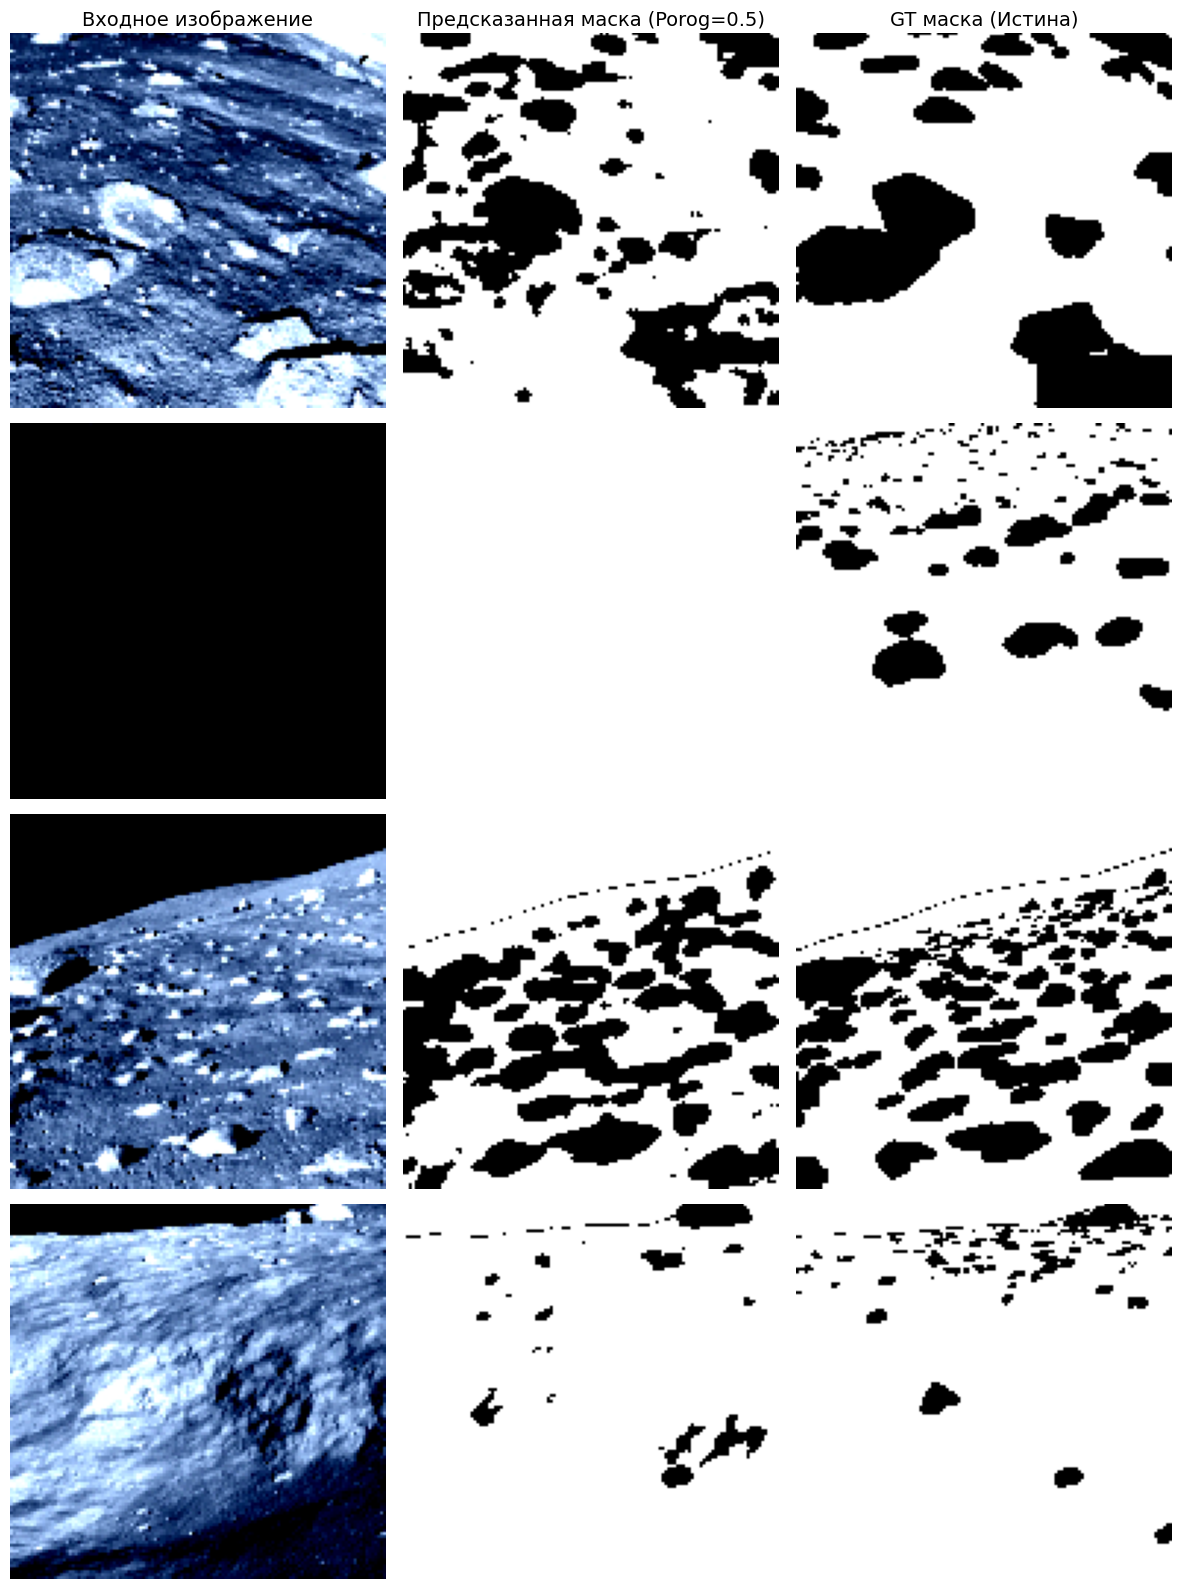

In [134]:
visualize_moon_segmentation(
    model=modelA, 
    dataloader=val_loader_moon, 
    device=device, 
    num_visualizations=4
)

Вариант B (тонкая настройка): полностью разморозить энкодер на поздних этапах

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = CustomEncoder()
state_dict = torch.load(
    "tiny_model_trained_model_ResNet.pth",
    map_location=device
)
encoder.load_state_dict(state_dict, strict=False)


C:\Users\Xenia\AppData\Local\Temp\ipykernel_22240\852174412.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])

In [106]:
modelB = MoonUNetBackbone(encoder, out_channels=1)
modelB = modelB.to(device)
criterion = BCEDiceLoss()
optimizerB = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, modelB.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

schedulerB = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizerB,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True
)


c:\Users\Xenia\anaconda3\envs\cv_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [107]:
for param in modelB.encoder.parameters():
    param.requires_grad = False

Обучение (замороженный энкодер)

In [115]:
epochs_1 = 25

modelB_first, history_B_first = train_moon(
    model=modelB,
    train_loader=train_loader_moon,
    val_loader=val_loader_moon,
    criterion=criterion,
    optimizer=optimizerB,
    scheduler=schedulerB,
    epochs=epochs_1,
    device=device
)


Epoch 1/25: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 1:
Train | Loss: 0.2911 | IoU: 0.5366 | Dice: 0.6976 | Acc: 0.9198
Val   | Loss: 0.3072 | IoU: 0.5117 | Dice: 0.6764 | Acc: 0.9112
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/25: 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]



Results Epoch 2:
Train | Loss: 0.3011 | IoU: 0.5227 | Dice: 0.6855 | Acc: 0.9159
Val   | Loss: 0.2951 | IoU: 0.5085 | Dice: 0.6740 | Acc: 0.9279
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/25: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 3:
Train | Loss: 0.2849 | IoU: 0.5446 | Dice: 0.7039 | Acc: 0.9219
Val   | Loss: 0.2822 | IoU: 0.5274 | Dice: 0.6905 | Acc: 0.9287
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/25: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]



Results Epoch 4:
Train | Loss: 0.2879 | IoU: 0.5423 | Dice: 0.7023 | Acc: 0.9203
Val   | Loss: 0.2995 | IoU: 0.5075 | Dice: 0.6727 | Acc: 0.9216
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/25: 100%|██████████| 25/25 [00:06<00:00,  3.91it/s]



Results Epoch 5:
Train | Loss: 0.2821 | IoU: 0.5498 | Dice: 0.7084 | Acc: 0.9227
Val   | Loss: 0.2795 | IoU: 0.5337 | Dice: 0.6959 | Acc: 0.9295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/25: 100%|██████████| 25/25 [00:06<00:00,  3.85it/s]



Results Epoch 6:
Train | Loss: 0.2886 | IoU: 0.5402 | Dice: 0.7001 | Acc: 0.9201
Val   | Loss: 0.2835 | IoU: 0.5236 | Dice: 0.6872 | Acc: 0.9296
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/25: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 7:
Train | Loss: 0.2906 | IoU: 0.5376 | Dice: 0.6984 | Acc: 0.9195
Val   | Loss: 0.2860 | IoU: 0.5282 | Dice: 0.6910 | Acc: 0.9251
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/25: 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]



Results Epoch 8:
Train | Loss: 0.2911 | IoU: 0.5351 | Dice: 0.6958 | Acc: 0.9204
Val   | Loss: 0.2791 | IoU: 0.5403 | Dice: 0.7015 | Acc: 0.9251
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/25: 100%|██████████| 25/25 [00:06<00:00,  3.95it/s]



Results Epoch 9:
Train | Loss: 0.2823 | IoU: 0.5491 | Dice: 0.7079 | Acc: 0.9224
Val   | Loss: 0.2773 | IoU: 0.5413 | Dice: 0.7023 | Acc: 0.9267
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/25: 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]



Results Epoch 10:
Train | Loss: 0.2812 | IoU: 0.5501 | Dice: 0.7091 | Acc: 0.9227
Val   | Loss: 0.2777 | IoU: 0.5345 | Dice: 0.6966 | Acc: 0.9298
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/25: 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]



Results Epoch 11:
Train | Loss: 0.2735 | IoU: 0.5606 | Dice: 0.7178 | Acc: 0.9251
Val   | Loss: 0.2836 | IoU: 0.5290 | Dice: 0.6917 | Acc: 0.9283
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/25: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]



Results Epoch 12:
Train | Loss: 0.2797 | IoU: 0.5498 | Dice: 0.7085 | Acc: 0.9235
Val   | Loss: 0.2852 | IoU: 0.5248 | Dice: 0.6881 | Acc: 0.9251
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/25: 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]



Results Epoch 13:
Train | Loss: 0.2780 | IoU: 0.5561 | Dice: 0.7138 | Acc: 0.9229
Val   | Loss: 0.2803 | IoU: 0.5335 | Dice: 0.6956 | Acc: 0.9266
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/25: 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]



Results Epoch 14:
Train | Loss: 0.2763 | IoU: 0.5547 | Dice: 0.7129 | Acc: 0.9244
Val   | Loss: 0.2800 | IoU: 0.5278 | Dice: 0.6909 | Acc: 0.9307
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/25: 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]



Results Epoch 15:
Train | Loss: 0.2680 | IoU: 0.5679 | Dice: 0.7236 | Acc: 0.9269
Val   | Loss: 0.2714 | IoU: 0.5453 | Dice: 0.7057 | Acc: 0.9297
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 16/25: 100%|██████████| 25/25 [00:06<00:00,  3.82it/s]



Results Epoch 16:
Train | Loss: 0.2641 | IoU: 0.5720 | Dice: 0.7265 | Acc: 0.9279
Val   | Loss: 0.2689 | IoU: 0.5497 | Dice: 0.7093 | Acc: 0.9295
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 17/25: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 17:
Train | Loss: 0.2622 | IoU: 0.5785 | Dice: 0.7318 | Acc: 0.9276
Val   | Loss: 0.2735 | IoU: 0.5425 | Dice: 0.7034 | Acc: 0.9310
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 18/25: 100%|██████████| 25/25 [00:06<00:00,  3.78it/s]



Results Epoch 18:
Train | Loss: 0.2643 | IoU: 0.5723 | Dice: 0.7264 | Acc: 0.9277
Val   | Loss: 0.2759 | IoU: 0.5425 | Dice: 0.7033 | Acc: 0.9266
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 19/25: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 19:
Train | Loss: 0.2596 | IoU: 0.5784 | Dice: 0.7319 | Acc: 0.9294
Val   | Loss: 0.2746 | IoU: 0.5449 | Dice: 0.7053 | Acc: 0.9262
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 20/25: 100%|██████████| 25/25 [00:06<00:00,  3.74it/s]



Results Epoch 20:
Train | Loss: 0.2603 | IoU: 0.5776 | Dice: 0.7314 | Acc: 0.9282
Val   | Loss: 0.2734 | IoU: 0.5439 | Dice: 0.7045 | Acc: 0.9287
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 21/25: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 21:
Train | Loss: 0.2603 | IoU: 0.5757 | Dice: 0.7291 | Acc: 0.9294
Val   | Loss: 0.2696 | IoU: 0.5463 | Dice: 0.7066 | Acc: 0.9321
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 22/25: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s]



Results Epoch 22:
Train | Loss: 0.2609 | IoU: 0.5788 | Dice: 0.7317 | Acc: 0.9281
Val   | Loss: 0.2670 | IoU: 0.5528 | Dice: 0.7120 | Acc: 0.9312
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 23/25: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 23:
Train | Loss: 0.2605 | IoU: 0.5760 | Dice: 0.7300 | Acc: 0.9302
Val   | Loss: 0.2676 | IoU: 0.5523 | Dice: 0.7116 | Acc: 0.9303
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 24/25: 100%|██████████| 25/25 [00:06<00:00,  3.75it/s]



Results Epoch 24:
Train | Loss: 0.2573 | IoU: 0.5838 | Dice: 0.7364 | Acc: 0.9291
Val   | Loss: 0.2670 | IoU: 0.5509 | Dice: 0.7104 | Acc: 0.9323
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 25/25: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 25:
Train | Loss: 0.2557 | IoU: 0.5847 | Dice: 0.7371 | Acc: 0.9304
Val   | Loss: 0.2641 | IoU: 0.5559 | Dice: 0.7145 | Acc: 0.9321
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Обучение (размороженный энкодер)

In [116]:
for param in modelB_first.encoder.parameters():
    param.requires_grad = True

In [117]:
optimizerB2 = torch.optim.AdamW(
    modelB_first.parameters(),
    lr=1e-4,        
    weight_decay=1e-4
)

schedulerB2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizerB2,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True
)


In [118]:
epochs_2 = 15
modelB_second, history_B_second = train_moon(
    model=modelB_first,
    train_loader=train_loader_moon,
    val_loader=val_loader_moon,
    criterion=criterion,
    optimizer=optimizerB2,
    scheduler=schedulerB2,
    epochs=epochs_2,
    device=device
)

Epoch 1/15: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s]



Results Epoch 1:
Train | Loss: 0.2570 | IoU: 0.5841 | Dice: 0.7354 | Acc: 0.9295
Val   | Loss: 0.2653 | IoU: 0.5544 | Dice: 0.7133 | Acc: 0.9321
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 2/15: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 2:
Train | Loss: 0.2545 | IoU: 0.5856 | Dice: 0.7379 | Acc: 0.9313
Val   | Loss: 0.2651 | IoU: 0.5572 | Dice: 0.7156 | Acc: 0.9309
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 3/15: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s]



Results Epoch 3:
Train | Loss: 0.2500 | IoU: 0.5921 | Dice: 0.7430 | Acc: 0.9322
Val   | Loss: 0.2647 | IoU: 0.5540 | Dice: 0.7130 | Acc: 0.9327
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 4/15: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]



Results Epoch 4:
Train | Loss: 0.2542 | IoU: 0.5871 | Dice: 0.7392 | Acc: 0.9304
Val   | Loss: 0.2642 | IoU: 0.5565 | Dice: 0.7150 | Acc: 0.9314
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 5/15: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]



Results Epoch 5:
Train | Loss: 0.2541 | IoU: 0.5879 | Dice: 0.7395 | Acc: 0.9310
Val   | Loss: 0.2670 | IoU: 0.5498 | Dice: 0.7095 | Acc: 0.9318
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 6/15: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]



Results Epoch 6:
Train | Loss: 0.2506 | IoU: 0.5918 | Dice: 0.7425 | Acc: 0.9315
Val   | Loss: 0.2626 | IoU: 0.5604 | Dice: 0.7182 | Acc: 0.9311
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 7/15: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s]



Results Epoch 7:
Train | Loss: 0.2516 | IoU: 0.5912 | Dice: 0.7420 | Acc: 0.9314
Val   | Loss: 0.2651 | IoU: 0.5540 | Dice: 0.7129 | Acc: 0.9315
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 8/15: 100%|██████████| 25/25 [00:06<00:00,  3.70it/s]



Results Epoch 8:
Train | Loss: 0.2522 | IoU: 0.5893 | Dice: 0.7407 | Acc: 0.9314
Val   | Loss: 0.2640 | IoU: 0.5588 | Dice: 0.7169 | Acc: 0.9309
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 9/15: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]



Results Epoch 9:
Train | Loss: 0.2574 | IoU: 0.5813 | Dice: 0.7343 | Acc: 0.9305
Val   | Loss: 0.2656 | IoU: 0.5531 | Dice: 0.7122 | Acc: 0.9317
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 10/15: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]



Results Epoch 10:
Train | Loss: 0.2501 | IoU: 0.5930 | Dice: 0.7432 | Acc: 0.9320
Val   | Loss: 0.2612 | IoU: 0.5621 | Dice: 0.7196 | Acc: 0.9317
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 11/15: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]



Results Epoch 11:
Train | Loss: 0.2477 | IoU: 0.5963 | Dice: 0.7463 | Acc: 0.9327
Val   | Loss: 0.2623 | IoU: 0.5587 | Dice: 0.7168 | Acc: 0.9319
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 12/15: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]



Results Epoch 12:
Train | Loss: 0.2545 | IoU: 0.5852 | Dice: 0.7369 | Acc: 0.9311
Val   | Loss: 0.2682 | IoU: 0.5470 | Dice: 0.7070 | Acc: 0.9324
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 13/15: 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]



Results Epoch 13:
Train | Loss: 0.2491 | IoU: 0.5930 | Dice: 0.7437 | Acc: 0.9326
Val   | Loss: 0.2632 | IoU: 0.5572 | Dice: 0.7156 | Acc: 0.9325
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 14/15: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]



Results Epoch 14:
Train | Loss: 0.2504 | IoU: 0.5913 | Dice: 0.7420 | Acc: 0.9313
Val   | Loss: 0.2628 | IoU: 0.5583 | Dice: 0.7164 | Acc: 0.9313
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Epoch 15/15: 100%|██████████| 25/25 [00:06<00:00,  3.71it/s]



Results Epoch 15:
Train | Loss: 0.2492 | IoU: 0.5923 | Dice: 0.7428 | Acc: 0.9326
Val   | Loss: 0.2624 | IoU: 0.5589 | Dice: 0.7169 | Acc: 0.9312
 ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^  ^-^ 


Итоговые метрики  
Epoch 15:
* Train: Loss: 0.2492, IoU: 0.5923, Dice: 0.7428, Acc: 0.9326
* Val: Loss: 0.2624, IoU: 0.5589, Dice: 0.7169, Acc: 0.9312  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.012549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.04305013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.012549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9776906].


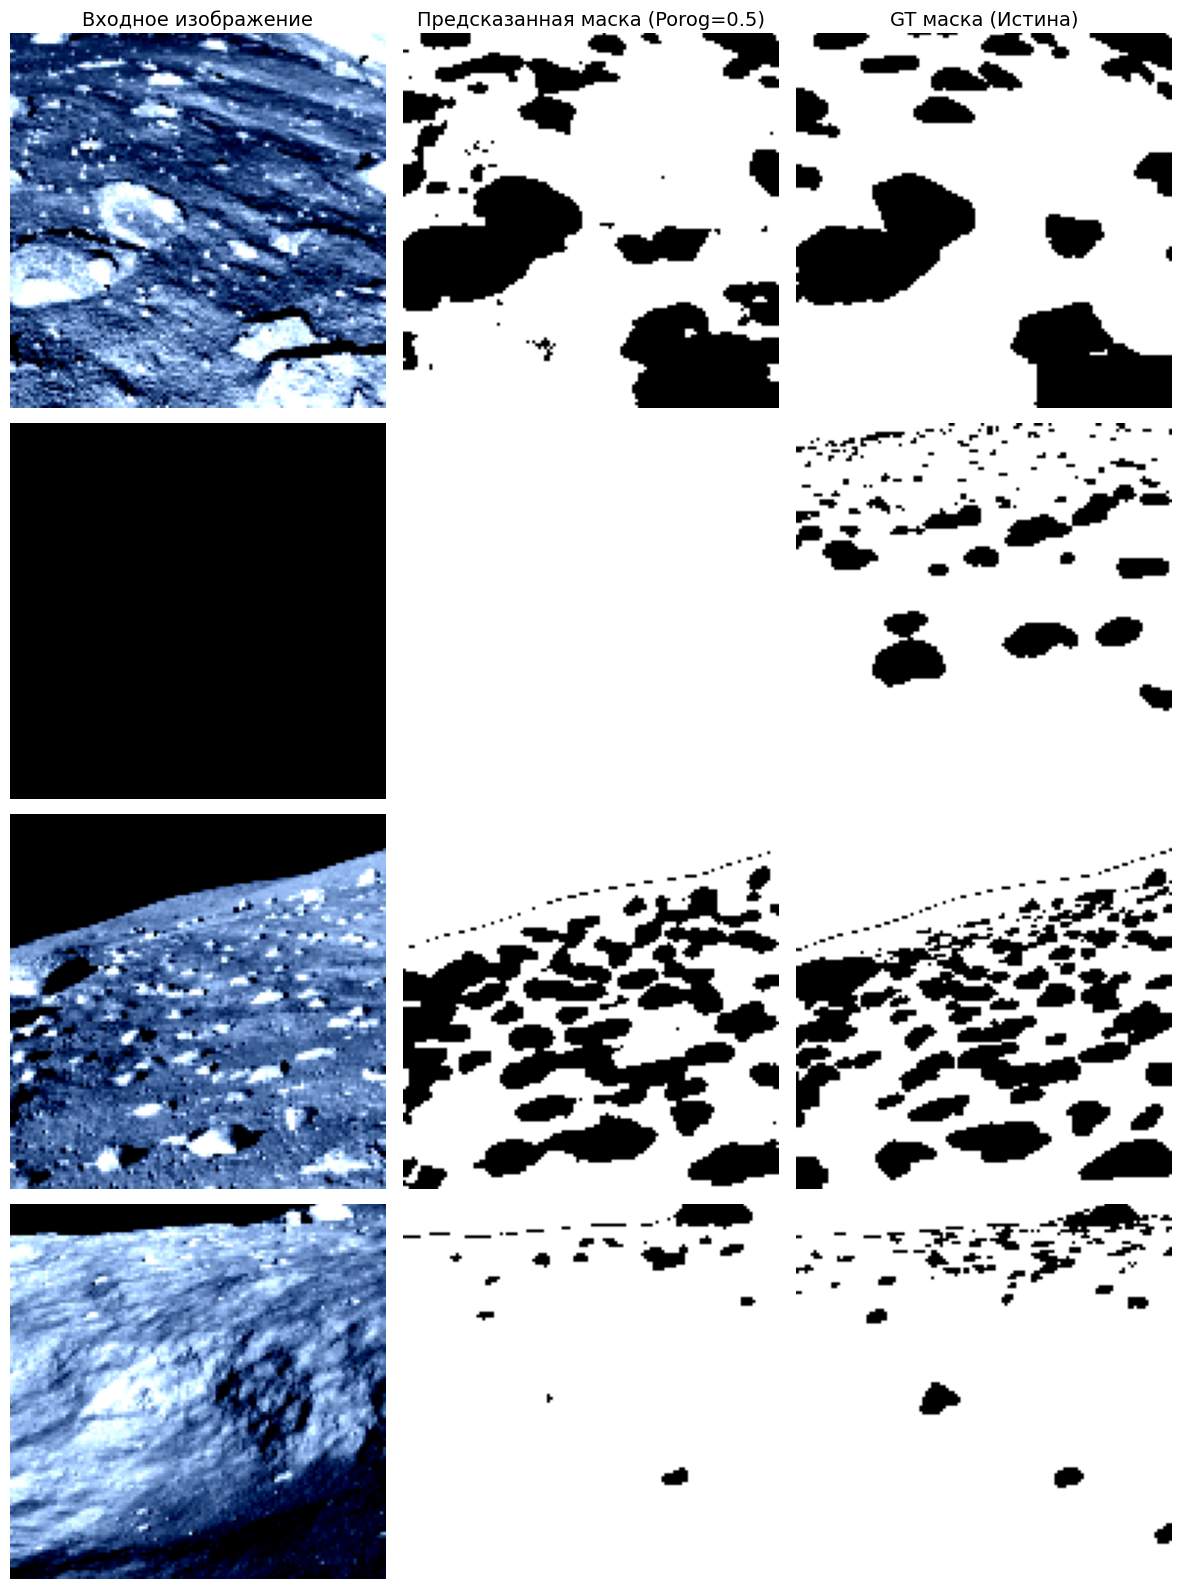

In [137]:
visualize_moon_segmentation(
    model=modelB_second, 
    dataloader=val_loader_moon, 
    device=device, 
    num_visualizations=4
)

Данная моденль дает лучший резульата из всех

| Модель                                   | IoU ↑     | Dice ↑    | Pixel Acc ↑ |
| ---------------------------------------- | --------- | --------- | ----------- |
| **Базовая U-Net (часть 2)**              | 0.492     | 0.659     | 0.919       |
| **U-Net + backbone (A: encoder frozen)** | 0.521     | 0.684     | 0.925       |
| **U-Net + backbone (B: fine-tuning)**    | **0.559** | **0.717** | **0.931**   |
